![image.png](attachment:image.png)

# Tarefa II

Neste projeto, estamos construindo um credit scoring para cartão de crédito, em um desenho amostral com 15 safras, e utilizando 12 meses de performance.

Carregue a base de dados ```credit_scoring.ftr```.

In [1]:
#!pip install pycaret

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import numpy as np

import statsmodels.formula.api as smf
import statsmodels.api as sm

from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics
from scipy.stats import ks_2samp
from scipy.stats import t
import warnings
warnings.filterwarnings('ignore')

from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

from pycaret.classification import *

df = pd.read_feather('credit_scoring.ftr')
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


## Amostragem

Separe os três últimos meses como safras de validação *out of time* (oot).

Variáveis:<br>
Considere que a variável ```data_ref``` não é uma variável explicativa, é somente uma variável indicadora da safra, e não deve ser utilizada na modelagem. A variávei ```index``` é um identificador do cliente, e também não deve ser utilizada como covariável (variável explicativa). As restantes podem ser utilizadas para prever a inadimplência, incluindo a renda.


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   data_ref               750000 non-null  datetime64[ns]
 1   index                  750000 non-null  int64         
 2   sexo                   750000 non-null  object        
 3   posse_de_veiculo       750000 non-null  object        
 4   posse_de_imovel        750000 non-null  object        
 5   qtd_filhos             750000 non-null  int64         
 6   tipo_renda             750000 non-null  object        
 7   educacao               750000 non-null  object        
 8   estado_civil           750000 non-null  object        
 9   tipo_residencia        750000 non-null  object        
 10  idade                  750000 non-null  int64         
 11  tempo_emprego          624043 non-null  float64       
 12  qt_pessoas_residencia  750000 non-null  floa

In [4]:
# Data máxima que temos no DataFrame
df['data_ref'].max()

Timestamp('2016-03-01 00:00:00')

In [5]:
# Data mínima que temos no DataFrame
df['data_ref'].min()

Timestamp('2015-01-01 00:00:00')

In [6]:
# Colocando 'data_ref como indice
df.set_index('data_ref', inplace=True)

# Separando os 3 ultimos meses em outro dataframe (outoftime = oot)
df_ = df[:'2015-12-01']
df_oot = df['2016-01-01':]

## Descritiva básica univariada

- Descreva a base quanto ao número de linhas, número de linhas para cada mês em ```data_ref```.
- Faça uma descritiva básica univariada de cada variável. Considere as naturezas diferentes: qualitativas e quantitativas.

In [7]:
# REsetando Indice do DataFrame sem os últimos 3 meses
df_.reset_index(inplace=True)

In [8]:
# Fazendo contagem dos meses

df_['mes'] = df_['data_ref'].dt.month
df_['mes'].value_counts()

,count
mes,
1,50000
2,50000
3,50000
4,50000
5,50000
6,50000
7,50000
8,50000
9,50000


In [9]:
# Dropando as colunas 'data_ref', 'index', 'mes'.
df_.drop(columns=['data_ref', 'index', 'mes'], inplace=True)

## Análise Univariada Qualitativa

In [10]:
df_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600000 entries, 0 to 599999
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   sexo                   600000 non-null  object 
 1   posse_de_veiculo       600000 non-null  object 
 2   posse_de_imovel        600000 non-null  object 
 3   qtd_filhos             600000 non-null  int64  
 4   tipo_renda             600000 non-null  object 
 5   educacao               600000 non-null  object 
 6   estado_civil           600000 non-null  object 
 7   tipo_residencia        600000 non-null  object 
 8   idade                  600000 non-null  int64  
 9   tempo_emprego          499125 non-null  float64
 10  qt_pessoas_residencia  600000 non-null  float64
 11  renda                  600000 non-null  float64
 12  mau                    600000 non-null  bool   
dtypes: bool(1), float64(3), int64(2), object(7)
memory usage: 55.5+ MB


In [11]:
# Separando variáveis qualitativas
qualitativas = df_.select_dtypes(include=['object', 'category', 'bool'])
qualitativas

,sexo,posse_de_veiculo,posse_de_imovel,tipo_renda,educacao,estado_civil,tipo_residencia,mau
0,F,N,N,Empresário,Médio,Solteiro,Casa,False
1,F,S,S,Assalariado,Médio,Casado,Casa,False
2,F,N,N,Assalariado,Médio,Casado,Casa,False
3,F,N,N,Assalariado,Médio,Casado,Casa,False
4,F,S,N,Assalariado,Superior incompleto,Solteiro,Casa,False
...,...,...,...,...,...,...,...,...
599995,F,S,N,Assalariado,Médio,União,Casa,False
599996,M,S,N,Empresário,Superior completo,Casado,Casa,False
599997,F,N,N,Pensionista,Médio,Casado,Casa,True
599998,F,N,N,Assalariado,Superior completo,Casado,Casa,True


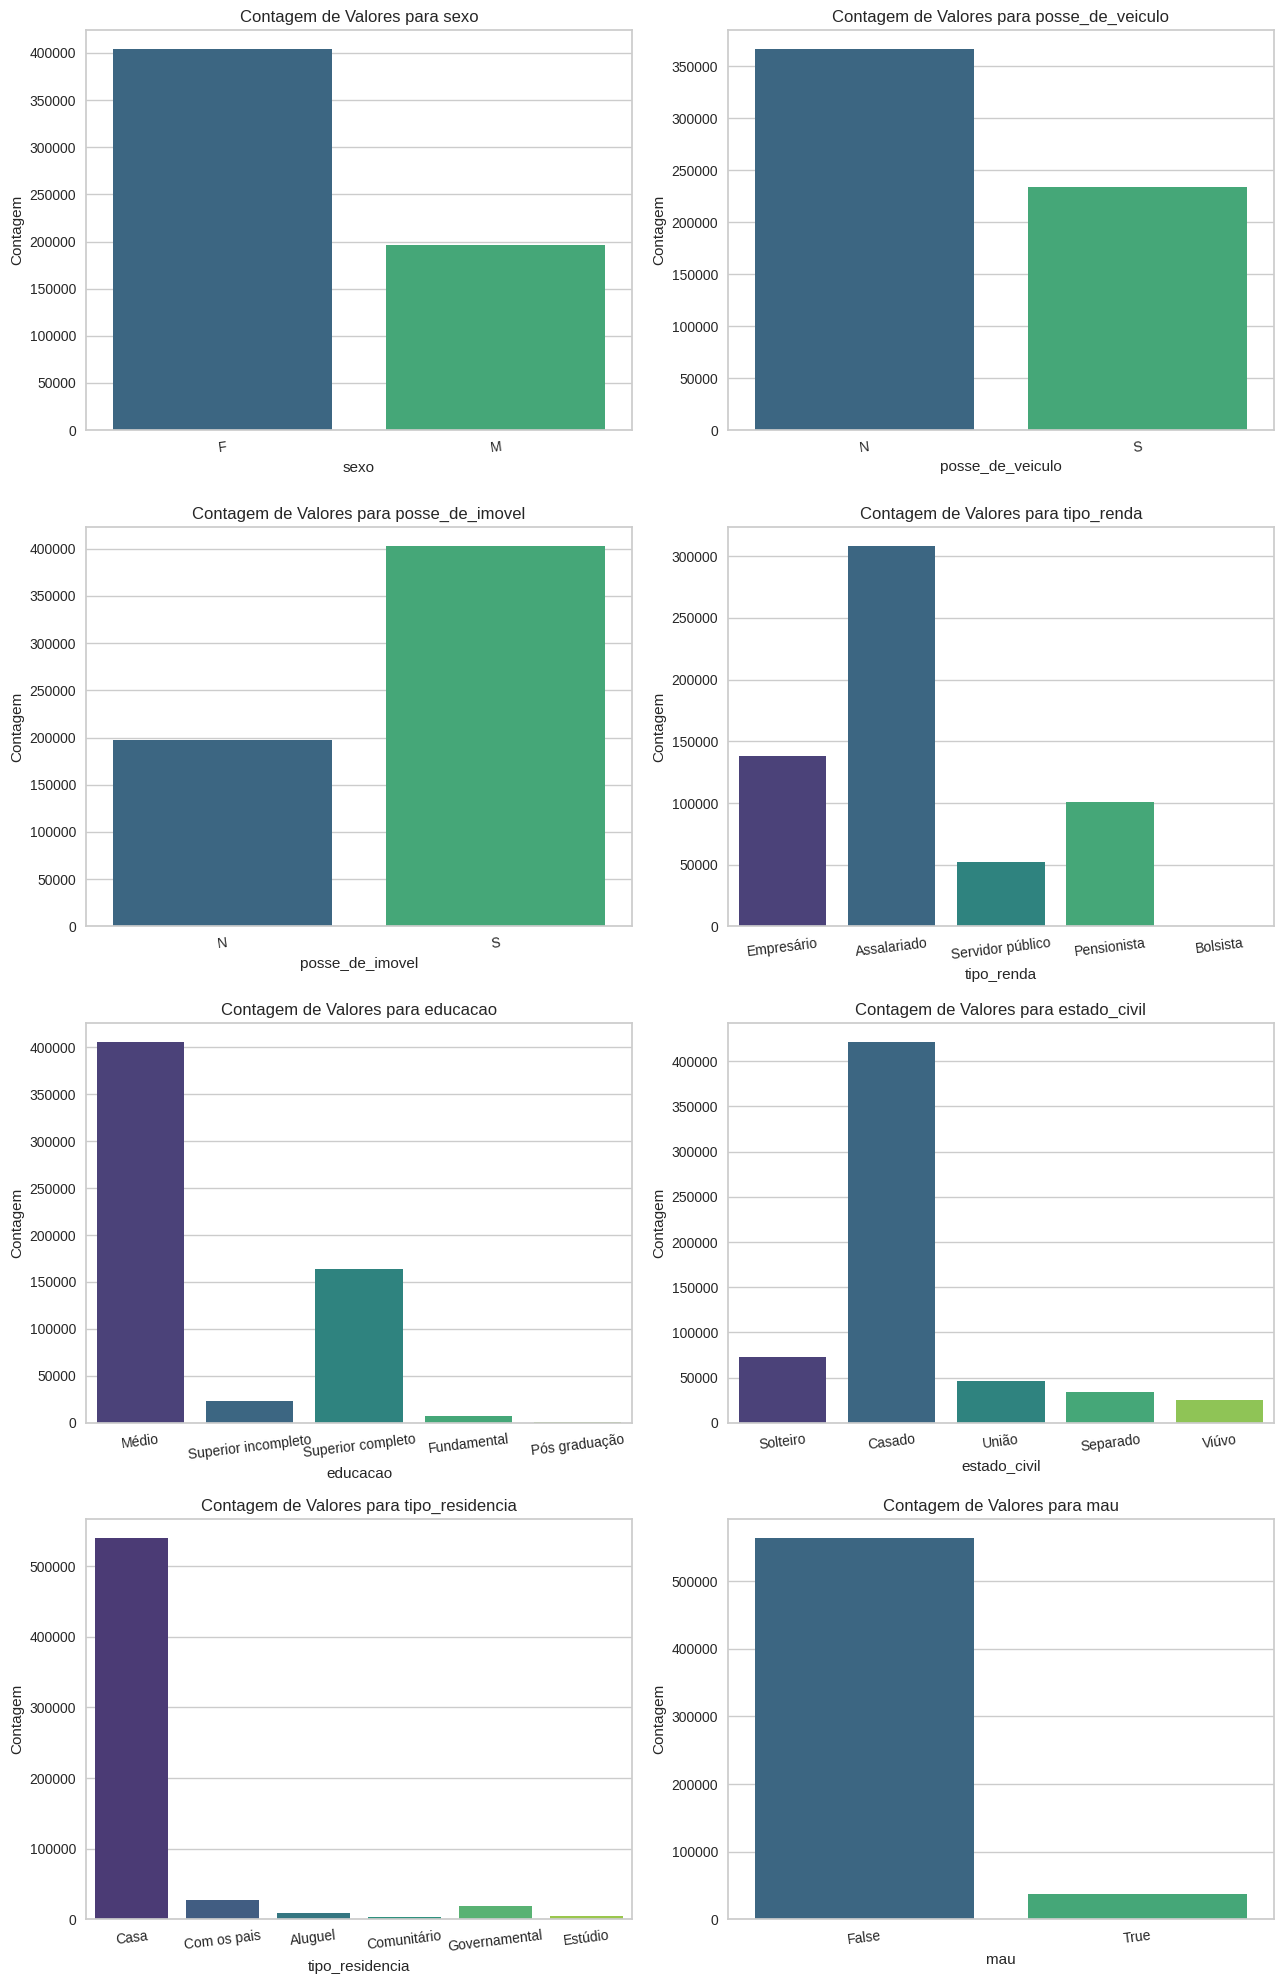

In [12]:
# Criando gráficos com variáveis qualitativas
# Determinar o número de linhas e colunas de subplots
num_qualitativas = len(qualitativas.columns)
cols = 2
rows = (num_qualitativas + 1) // cols

# Criar a figura com subplots
fig, axes = plt.subplots(rows, cols, figsize=(13, 5 * rows))
axes = axes.flatten()  # Achatar o array de eixos para fácil iteração

for i, col in enumerate(qualitativas.columns):
    # Plotar gráfico de barras para a contagem de valores
    sns.countplot(data=qualitativas, x=col, palette='viridis', ax=axes[i])
    axes[i].set_title(f'Contagem de Valores para {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Contagem')
    axes[i].tick_params(axis='x', rotation=7)

# Remover eixos não utilizados
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## Análise Univariada Quantitativa

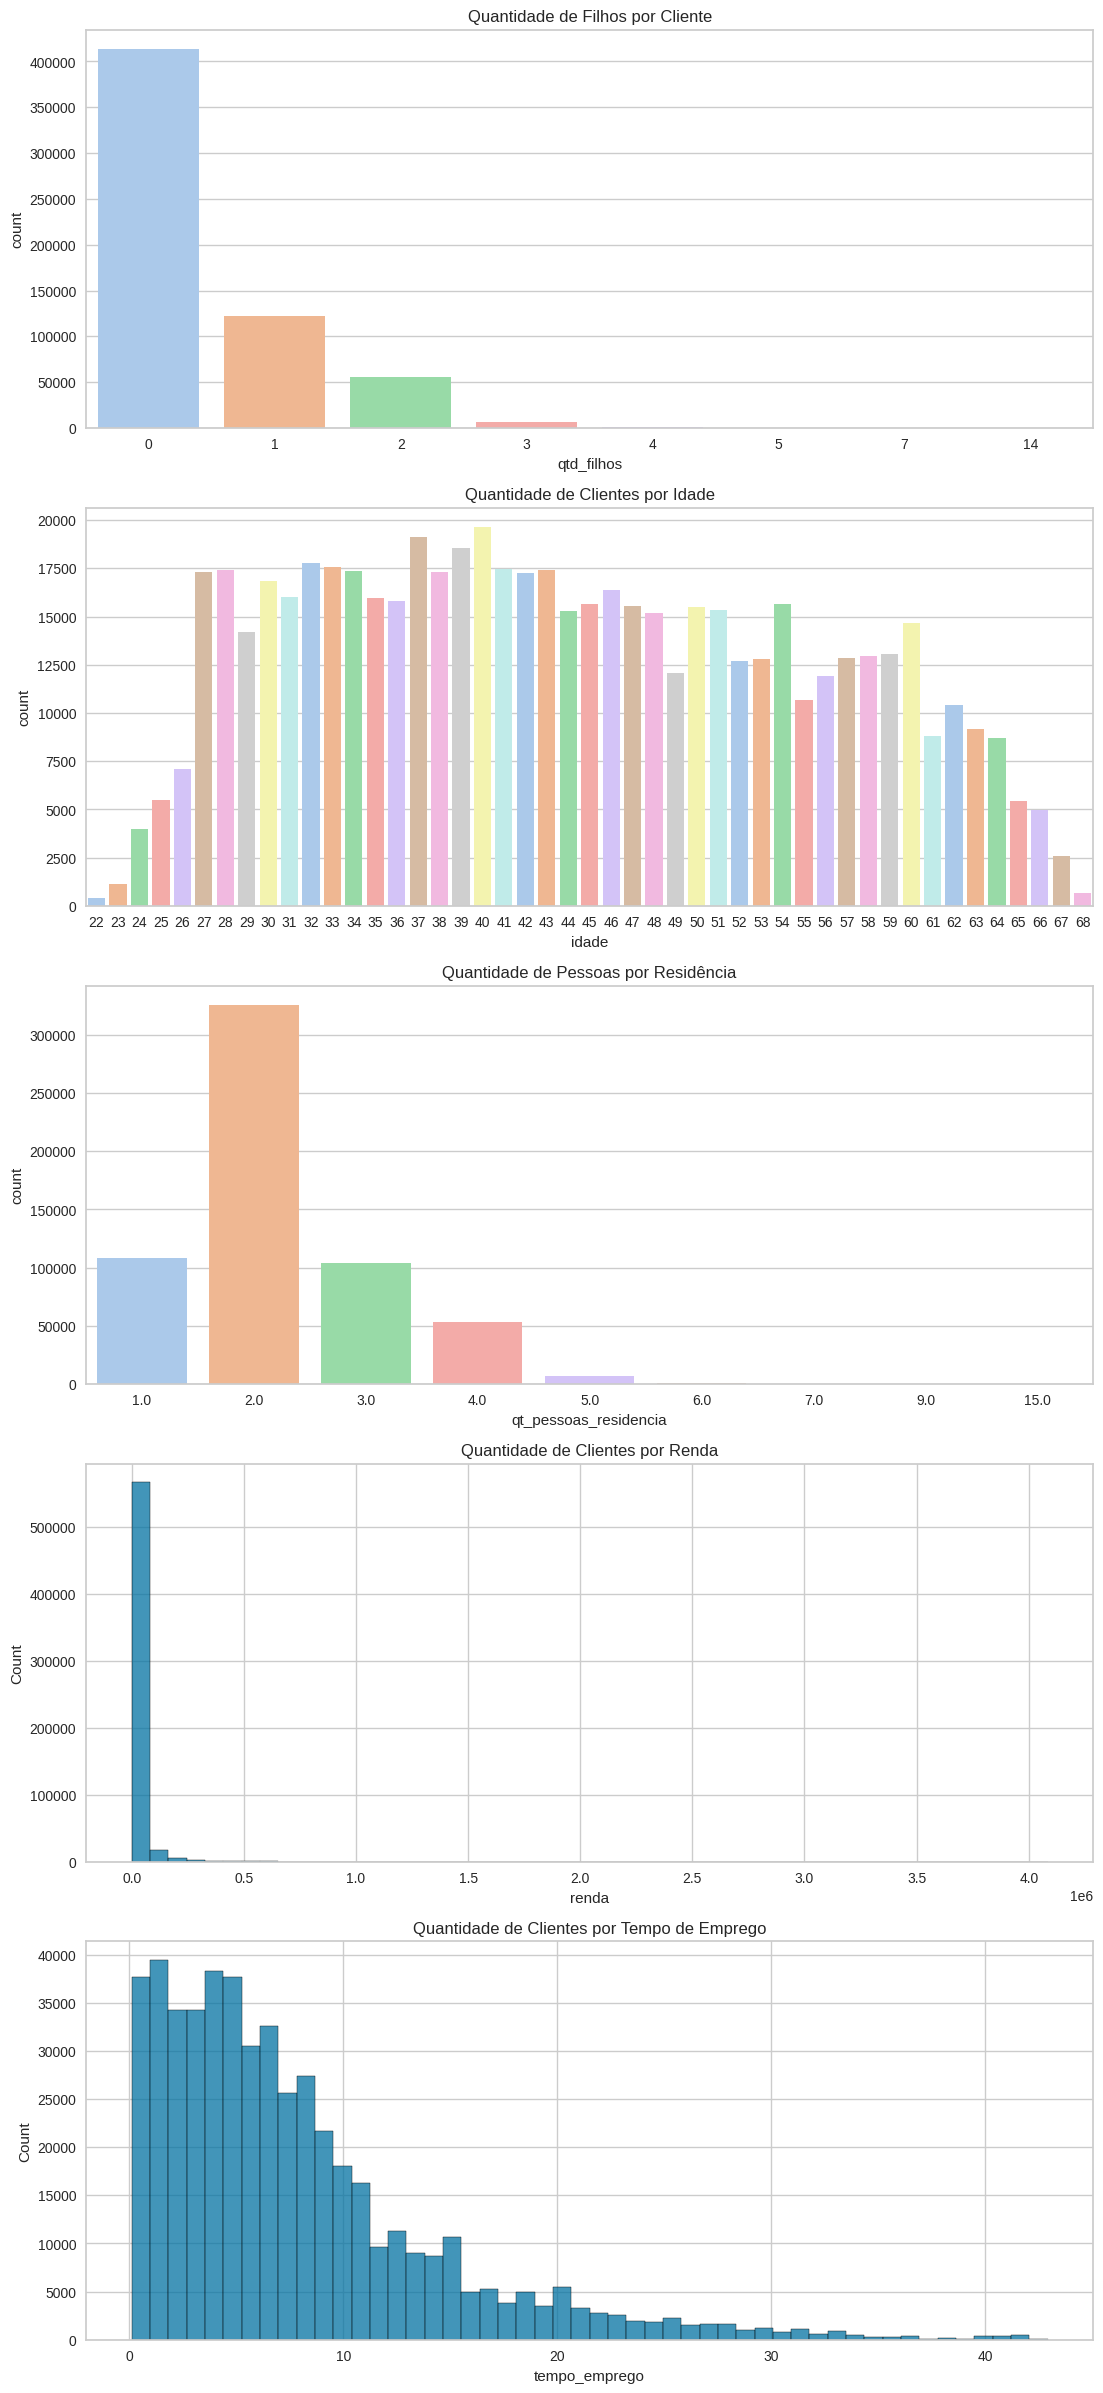

In [13]:
# Plotando Gráficos pra Análise das Variáveis Quantitativas

fig, ax = plt.subplots(nrows=5, ncols=1, figsize = (13, 30))

sns.countplot(data=df_, x='qtd_filhos', palette='pastel', ax=ax[0])
ax[0].set_title('Quantidade de Filhos por Cliente')

sns.countplot(data=df_, x='idade', palette='pastel', ax=ax[1])
ax[1].set_title('Quantidade de Clientes por Idade')

sns.countplot(data=df_, x='qt_pessoas_residencia', palette='pastel', ax=ax[2])
ax[2].set_title('Quantidade de Pessoas por Residência')

sns.histplot(data=df_, x='renda', bins = 50, palette='pastel', ax=ax[3])
ax[3].set_title('Quantidade de Clientes por Renda')

sns.histplot(data=df_, x='tempo_emprego', bins = 50, palette='pastel', ax=ax[4])
ax[4].set_title('Quantidade de Clientes por Tempo de Emprego')

plt.show()

## Descritiva bivariada

Faça uma análise descritiva bivariada de cada variável

## Bivariada Descritiva

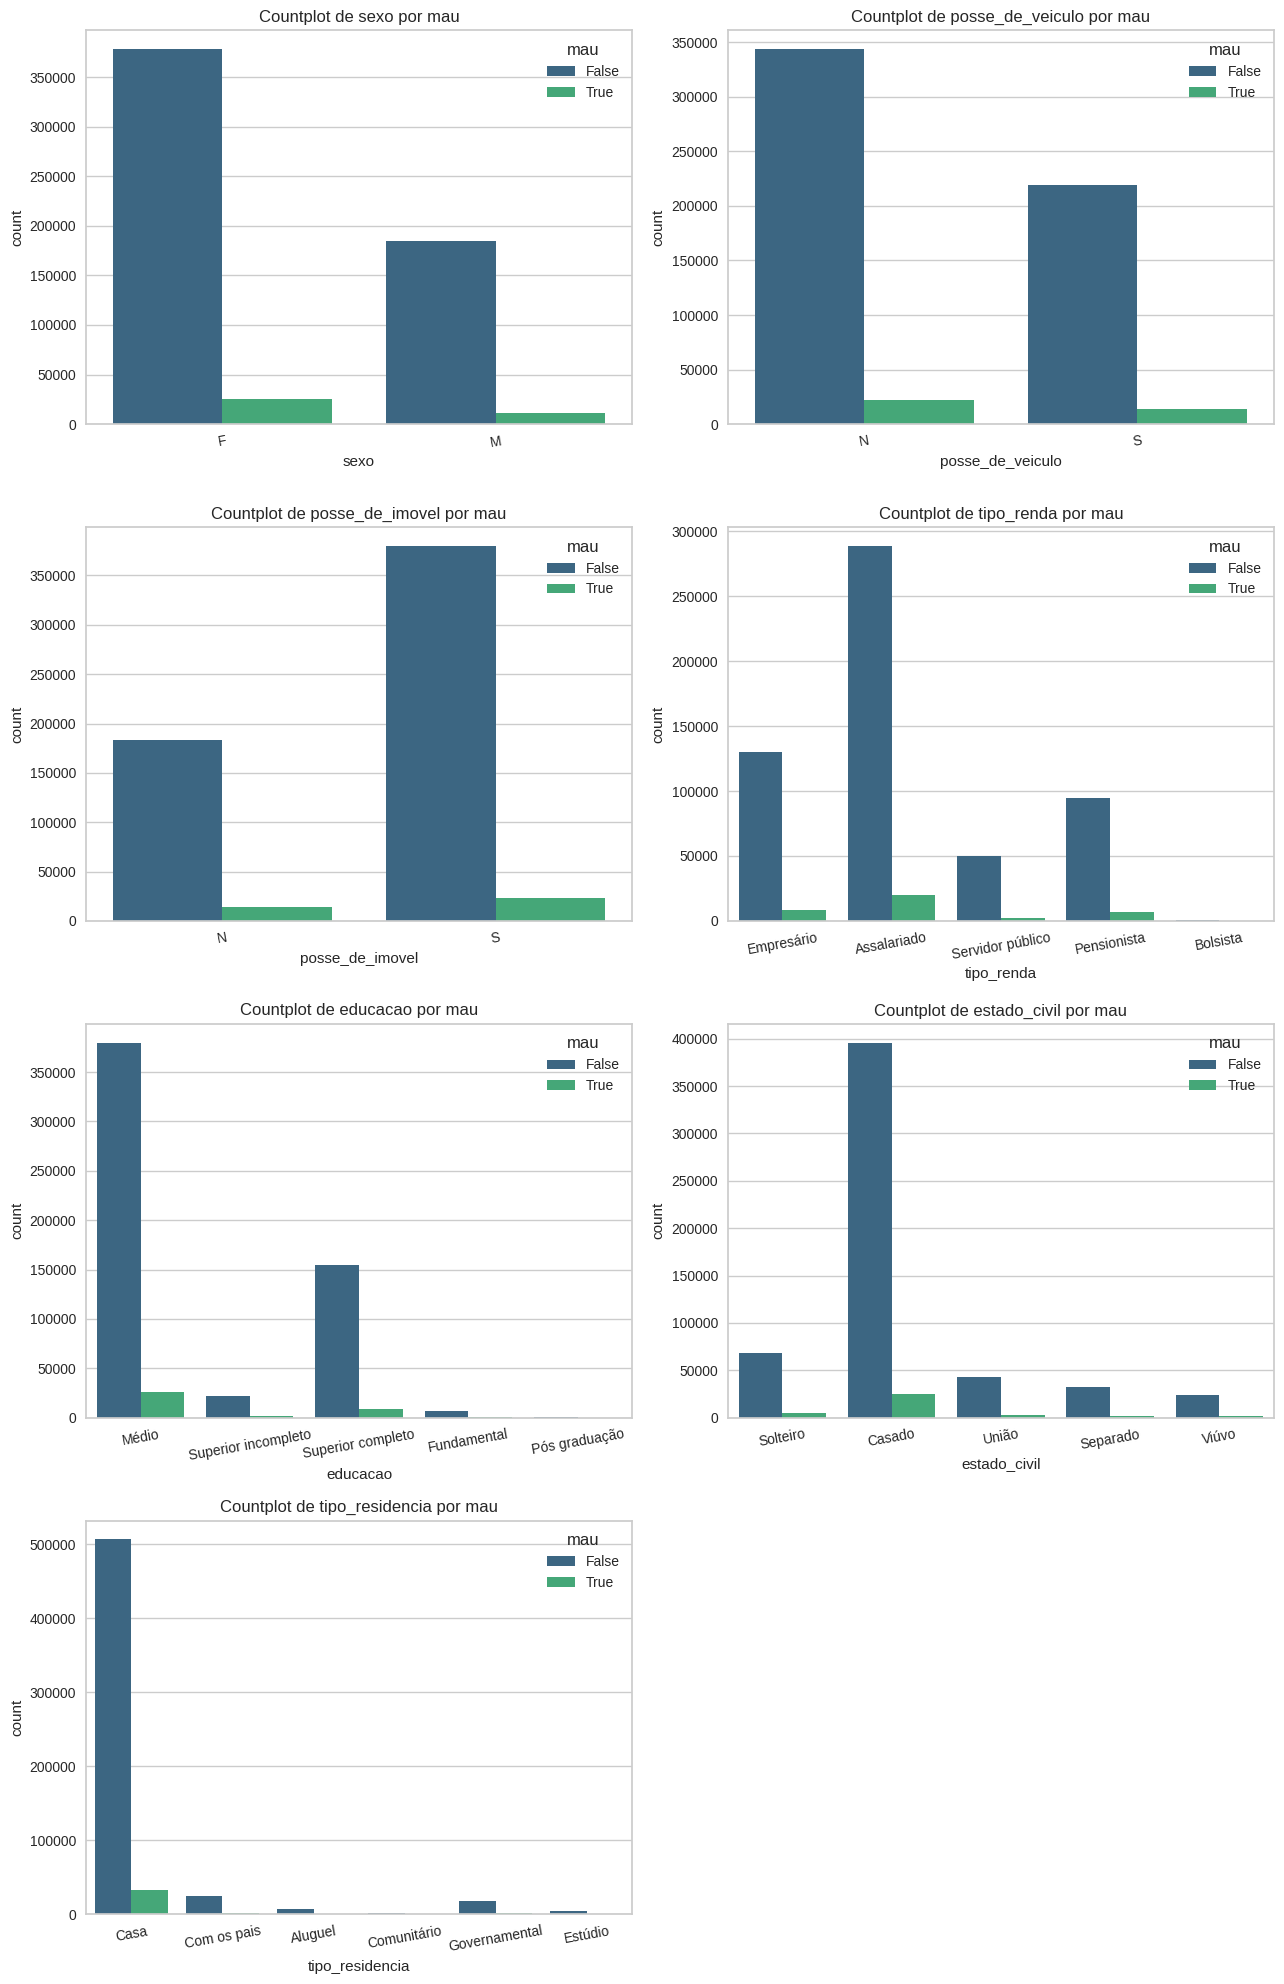

[('sexo',
  mau     False   True   Total
  sexo                        
  F      378318  25487  403805
  M      185039  11156  196195
  Total  563357  36643  600000),
 ('posse_de_veiculo',
  mau                False   True   Total
  posse_de_veiculo                       
  N                 343778  22515  366293
  S                 219579  14128  233707
  Total             563357  36643  600000),
 ('posse_de_imovel',
  mau               False   True   Total
  posse_de_imovel                       
  N                183305  13641  196946
  S                380052  23002  403054
  Total            563357  36643  600000),
 ('tipo_renda',
  mau                False   True   Total
  tipo_renda                             
  Assalariado       288865  19595  308460
  Bolsista             279     12     291
  Empresário        129935   8206  138141
  Pensionista        94627   6500  101127
  Servidor público   49651   2330   51981
  Total             563357  36643  600000),
 ('educacao',
  m

In [14]:
# Análise descritiva bivariada entre variáveis categóricas e a variável resposta 'MAU'
def descritiva_bivariada_com_MAU(df, resposta='mau'):
    cat_cols = qualitativas.columns
    cat_cols = [col for col in cat_cols if col != resposta]

    num_plots = len(cat_cols)
    fig, axes = plt.subplots((num_plots + 1) // 2, 2, figsize=(13, 5 * ((num_plots + 1) // 2)))
    axes = axes.flatten()

    for i, col in enumerate(cat_cols):
        # Countplot para variáveis categóricas
        sns.countplot(data=df, x=col, hue=resposta, ax=axes[i], palette='viridis')
        axes[i].set_title(f'Countplot de {col} por {resposta}')

        # Alterar o ângulo dos rótulos do eixo x para todos os gráficos
        axes[i].tick_params(axis='x', rotation=10)

     # Remover eixos não utilizados
    for j in range(num_plots, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

        # Criar tabela com distribuição das variáveis categóricas
    tables = []
    for col in cat_cols:
        table = pd.crosstab(df[col], df[resposta], margins=True, margins_name='Total')
        tables.append((col, table))

    return tables

# Executar a análise
descritiva_bivariada_com_MAU(df_)

In [15]:
# Função para criar tabelas de contingência
def create_contingency_tables(df, resposta='mau'):
    cat_cols = qualitativas.columns
    cat_cols = [col for col in cat_cols if col != resposta]

    contingency_tables = {}

    for col in cat_cols:
        # Criar tabela de contingência
        table = pd.crosstab(df[col], df[resposta], margins=True, margins_name='Total')
        contingency_tables[col] = table

    return contingency_tables

# Executar a criação das tabelas
contingency_tables = create_contingency_tables(df_)

# Exibir as tabelas
for col, table in contingency_tables.items():
    print(f'Tabela de contingência para {col}:\n')
    print(table)
    print('\n' + '='*80 + '\n')

Tabela de contingência para sexo:

mau     False   True   Total
sexo                        
F      378318  25487  403805
M      185039  11156  196195
Total  563357  36643  600000


Tabela de contingência para posse_de_veiculo:

mau                False   True   Total
posse_de_veiculo                       
N                 343778  22515  366293
S                 219579  14128  233707
Total             563357  36643  600000


Tabela de contingência para posse_de_imovel:

mau               False   True   Total
posse_de_imovel                       
N                183305  13641  196946
S                380052  23002  403054
Total            563357  36643  600000


Tabela de contingência para tipo_renda:

mau                False   True   Total
tipo_renda                             
Assalariado       288865  19595  308460
Bolsista             279     12     291
Empresário        129935   8206  138141
Pensionista        94627   6500  101127
Servidor público   49651   2330   51981
Total

## Bivariada Quantitativa

In [16]:
# Separar variáveis qualitativas e quantitativas
quantitativas = df_.select_dtypes(include=['number'])
quantitativas

,qtd_filhos,idade,tempo_emprego,qt_pessoas_residencia,renda
0,0,43,6.873973,1.0,2515.39
1,0,35,4.526027,2.0,3180.19
2,2,31,0.243836,4.0,1582.29
3,0,54,12.772603,2.0,13721.17
4,0,31,8.432877,1.0,2891.08
...,...,...,...,...,...
599995,0,47,23.690411,2.0,11009.92
599996,1,31,3.756164,3.0,4472.60
599997,0,62,NaN,2.0,5117.17
599998,0,40,12.939726,2.0,2885.45


In [17]:
# Obter o número de valores diferentes (únicos) de cada variável
unique_counts = quantitativas.nunique()
print('Número de valores diferentes em cada variável:')
print(unique_counts)

Número de valores diferentes em cada variável:
qtd_filhos                    8
idade                        47
tempo_emprego              3004
qt_pessoas_residencia         9
renda                    112472
dtype: int64


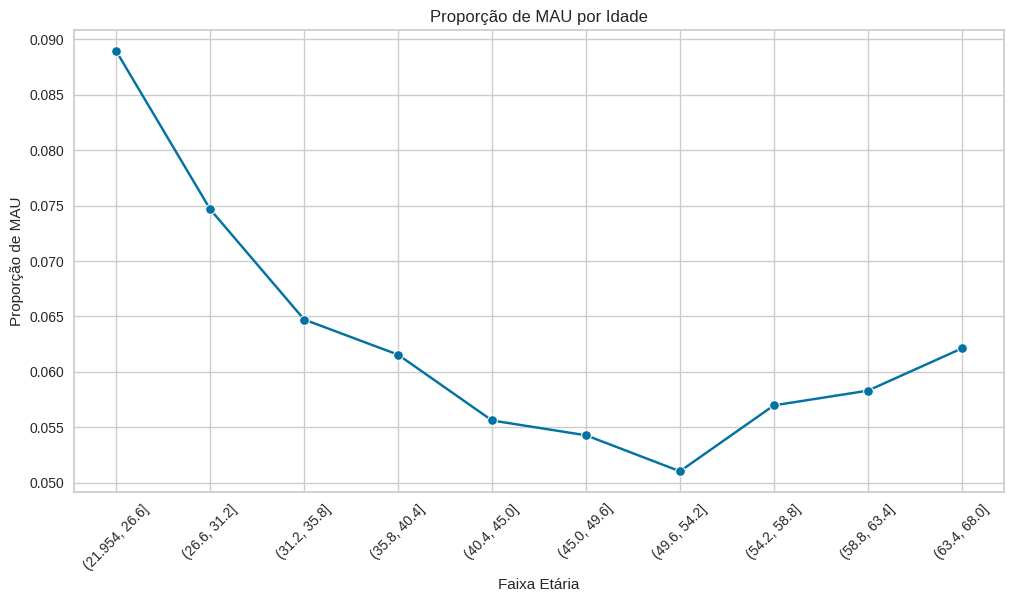

In [18]:
# Dividir a variável 'idade' em 10 intervalos
df_['idade_bin'] = pd.cut(df_['idade'], bins=10)

# Criar a figura e os eixos
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))

# Calcular a média de idade_bin para cada categoria de MAU
media_idade = df_.groupby('idade_bin')['mau'].mean().reset_index()

# Converter a 'idade_bin' para string
media_idade['idade_bin'] = media_idade['idade_bin'].astype(str)

sns.lineplot(data=media_idade, x='idade_bin', y='mau', marker='o', ax=ax)
plt.xticks(rotation=45)
plt.xlabel('Faixa Etária')
plt.ylabel('Proporção de MAU')
plt.title('Proporção de MAU por Idade')
plt.grid(True)
plt.show()

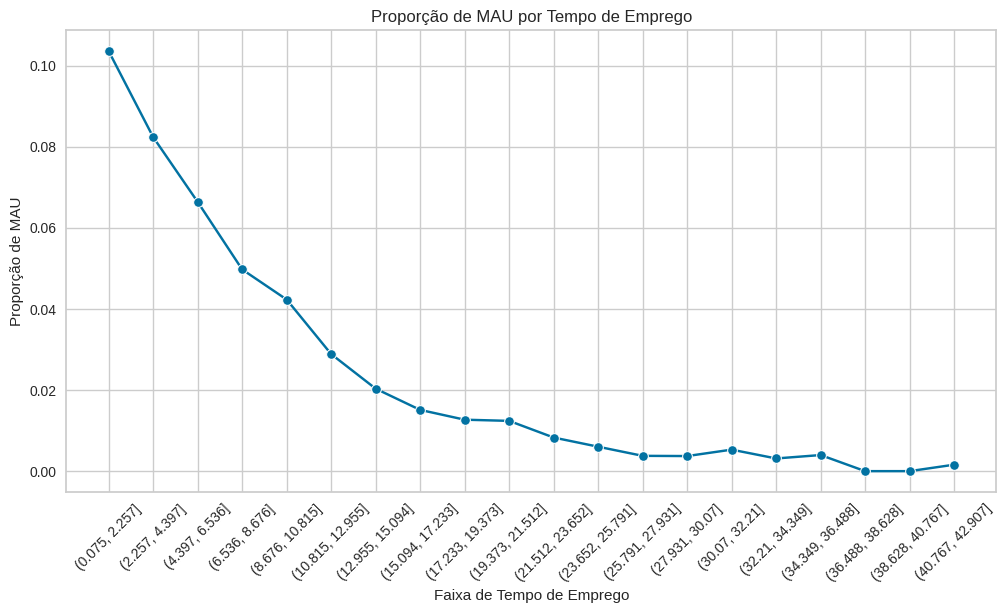

In [19]:
# Dividir a variável 'tempo_emprego' em 20 intervalos
df_['tempo_emprego_bin'] = pd.cut(df_['tempo_emprego'].to_numpy(), bins=20)

# Criar a figura e os eixos
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))

# Calcular a média de tempo_emprego para cada categoria de MAU
media_tempo_emprego = df_.groupby('tempo_emprego_bin')['mau'].mean().reset_index()

# Converter a 'tempo_emprego_bin' para string
media_tempo_emprego['tempo_emprego_bin'] = media_tempo_emprego['tempo_emprego_bin'].astype(str)

sns.lineplot(data=media_tempo_emprego, x='tempo_emprego_bin', y='mau', marker='o', ax=ax)
plt.xticks(rotation=45)
plt.xlabel('Faixa de Tempo de Emprego')
plt.ylabel('Proporção de MAU')
plt.title('Proporção de MAU por Tempo de Emprego')
plt.grid(True)
plt.show()

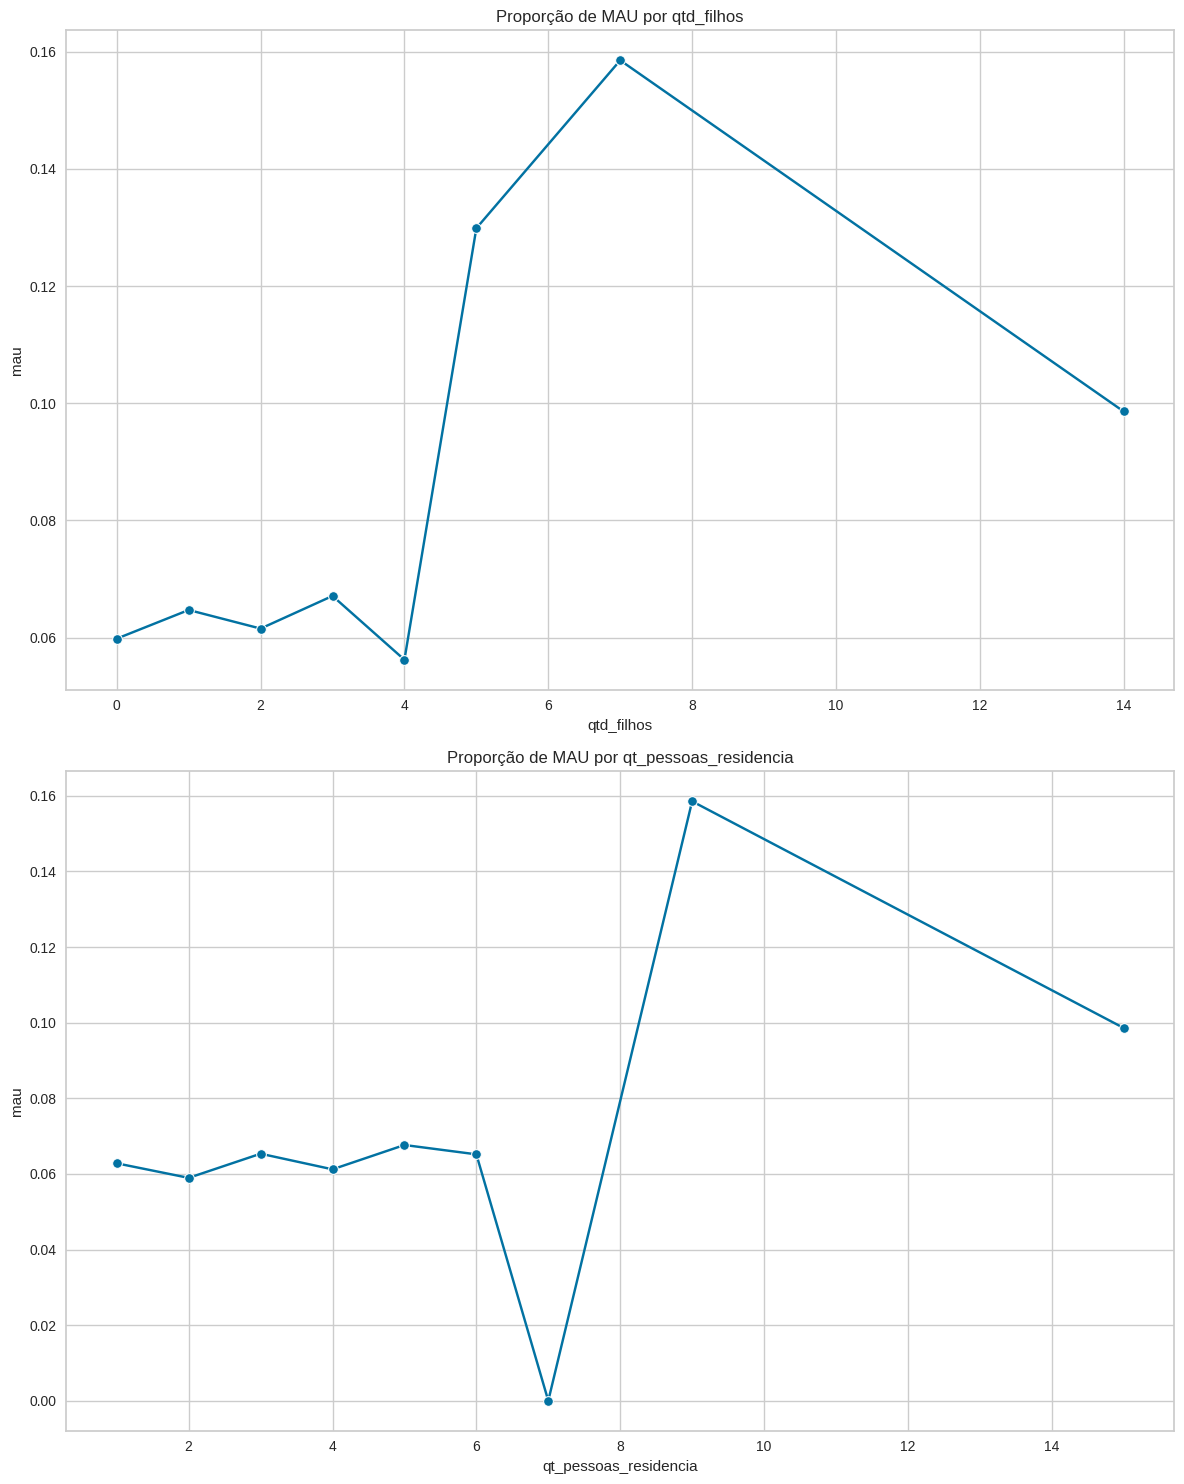

In [20]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize = (12, 15))

# Lineplot
# Calcular a média de qtd_filhos para cada categoria de MAU
media_filhos = df_.groupby('qtd_filhos')['mau'].mean().reset_index()

# Plotar o gráfico de linha
sns.lineplot(data=media_filhos, x='qtd_filhos', y='mau', marker='o', ax=ax[0])
ax[0].set_title('Proporção de MAU por qtd_filhos')
ax[0].grid(True)

media_pessoas_residencia = df_.groupby('qt_pessoas_residencia')['mau'].mean().reset_index()
sns.lineplot(data=media_pessoas_residencia, x='qt_pessoas_residencia', y='mau', marker='o', ax=ax[1])
ax[1].set_title('Proporção de MAU por qt_pessoas_residencia')
ax[1].grid(True)

plt.tight_layout()
plt.grid(True)
plt.show()

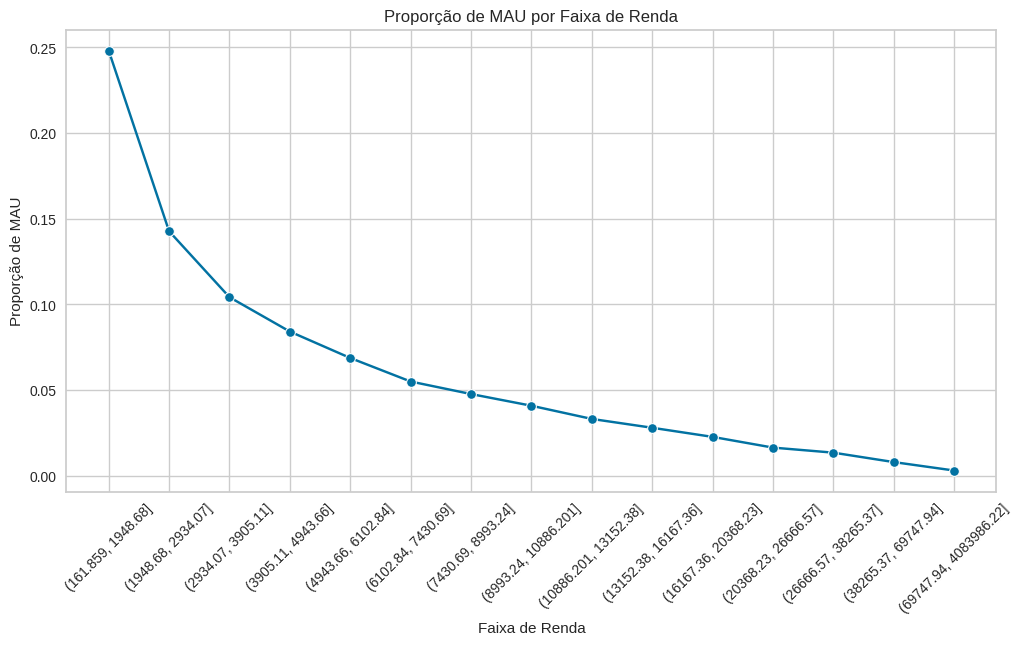

In [21]:
# Dividir a variável 'renda' em 15 intervalos
quebras = pd.qcut(df_['renda'], 15, duplicates='drop').cat.categories

df_['renda_bin'] = pd.cut(df_['renda'],
                          bins=quebras,
                          labels=quebras,
                          include_lowest=True
                          )

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))

# Lineplot
# Calcular a média de renda_bin para cada categoria de MAU
media_renda = df_.groupby('renda_bin')['mau'].mean().reset_index()

# Convert the 'renda_bin' categories to strings for plotting
media_renda['renda_bin'] = media_renda['renda_bin'].astype(str)

sns.lineplot(data=media_renda, x='renda_bin', y='mau', marker='o', ax=ax)
plt.xticks(rotation=45)
plt.xlabel('Faixa de Renda')
plt.ylabel('Proporção de MAU')
plt.title('Proporção de MAU por Faixa de Renda')
plt.grid(True)
plt.show()

## Desenvolvimento do modelo

Desenvolva um modelo de *credit scoring* através de uma regressão logística.

- Trate valores missings e outliers
- Trate 'zeros estruturais'
- Faça agrupamentos de categorias conforme vimos em aula
- Proponha uma equação preditiva para 'mau'
- Caso hajam categorias não significantes, justifique

In [22]:
df_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600000 entries, 0 to 599999
Data columns (total 16 columns):
 #   Column                 Non-Null Count   Dtype   
---  ------                 --------------   -----   
 0   sexo                   600000 non-null  object  
 1   posse_de_veiculo       600000 non-null  object  
 2   posse_de_imovel        600000 non-null  object  
 3   qtd_filhos             600000 non-null  int64   
 4   tipo_renda             600000 non-null  object  
 5   educacao               600000 non-null  object  
 6   estado_civil           600000 non-null  object  
 7   tipo_residencia        600000 non-null  object  
 8   idade                  600000 non-null  int64   
 9   tempo_emprego          499125 non-null  float64 
 10  qt_pessoas_residencia  600000 non-null  float64 
 11  renda                  600000 non-null  float64 
 12  mau                    600000 non-null  bool    
 13  idade_bin              600000 non-null  category
 14  tempo_emprego_bin   

In [23]:
# preenchendo os valores missing pela média de tempo de emprego
df_['tempo_emprego'] = df_['tempo_emprego'].fillna(df_['tempo_emprego'].mean())

# Transformando variável 'mau' em inteiro
df_['mau'] = df_['mau'].astype(int)

# Dropando variáveis que não vamos usar agora, foi apenas pra análise inicial
df_.drop(columns=['idade_bin', 'tempo_emprego_bin', 'renda_bin'], inplace=True)

In [24]:
df_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600000 entries, 0 to 599999
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   sexo                   600000 non-null  object 
 1   posse_de_veiculo       600000 non-null  object 
 2   posse_de_imovel        600000 non-null  object 
 3   qtd_filhos             600000 non-null  int64  
 4   tipo_renda             600000 non-null  object 
 5   educacao               600000 non-null  object 
 6   estado_civil           600000 non-null  object 
 7   tipo_residencia        600000 non-null  object 
 8   idade                  600000 non-null  int64  
 9   tempo_emprego          600000 non-null  float64
 10  qt_pessoas_residencia  600000 non-null  float64
 11  renda                  600000 non-null  float64
 12  mau                    600000 non-null  int64  
dtypes: float64(3), int64(3), object(7)
memory usage: 59.5+ MB


In [25]:
def IV(variavel, resposta):
    tab = pd.crosstab(variavel, resposta, margins=True, margins_name='total')

    rótulo_evento = tab.columns[0]
    rótulo_nao_evento = tab.columns[1]

    tab['pct_evento'] = tab[rótulo_evento]/tab.loc['total',rótulo_evento]
    tab['ep'] = tab[rótulo_evento]/tab.loc['total',rótulo_evento]

    tab['pct_nao_evento'] = tab[rótulo_nao_evento]/tab.loc['total',rótulo_nao_evento]
    tab['woe'] = np.log(tab.pct_evento/tab.pct_nao_evento)
    tab['iv_parcial'] = (tab.pct_evento - tab.pct_nao_evento)*tab.woe
    return tab['iv_parcial'].sum()

In [26]:
metadados = pd.DataFrame(df_.dtypes, columns=['dtype'])
metadados['nmissing'] = df_.isna().sum()
metadados['valores_unicos'] = df_.nunique()
metadados['papel'] = 'covariavel'
metadados.loc['mau','papel'] = 'resposta'
metadados

,dtype,nmissing,valores_unicos,papel
sexo,object,0,2,covariavel
posse_de_veiculo,object,0,2,covariavel
posse_de_imovel,object,0,2,covariavel
qtd_filhos,int64,0,8,covariavel
tipo_renda,object,0,5,covariavel
educacao,object,0,5,covariavel
estado_civil,object,0,5,covariavel
tipo_residencia,object,0,6,covariavel
idade,int64,0,47,covariavel
tempo_emprego,float64,0,3005,covariavel


### Iremos utilizar primeiramente o 'IV', que é uma métrica que resume a importância preditiva de uma variável.

Interpretação dos Valores de IV

    IV < 0.02: Preditor não útil
    0.02 ≤ IV < 0.1: Preditor fraco
    0.1 ≤ IV < 0.3: Preditor médio
    0.3 ≤ IV < 0.5: Preditor forte
    IV ≥ 0.5: Preditor suspeito (pode indicar overfitting)


In [27]:
for var in metadados[metadados.papel=='covariavel'].index:
    if  (metadados.loc[var, 'valores_unicos']>10):
        metadados.loc[var, 'IV'] = IV(pd.qcut(df_[var],5,duplicates='drop'),
                                      df_.mau)
    else:
        metadados.loc[var, 'IV'] = IV(df_[var], df_.mau)

    # Classificar o IV
    iv_value = metadados.loc[var, 'IV']
    if iv_value < 0.02:
        metadados.loc[var, 'Classificacao_IV'] = 'Não Útil'
    elif 0.02 <= iv_value < 0.1:
        metadados.loc[var, 'Classificacao_IV'] = 'Fraco'
    elif 0.1 <= iv_value < 0.3:
        metadados.loc[var, 'Classificacao_IV'] = 'Médio'
    elif 0.3 <= iv_value < 0.5:
        metadados.loc[var, 'Classificacao_IV'] = 'Forte'
    else:
        metadados.loc[var, 'Classificacao_IV'] = 'Muito Forte (Suspeito)'

metadados

,dtype,nmissing,valores_unicos,papel,IV,Classificacao_IV
sexo,object,0,2,covariavel,0.002665,Não Útil
posse_de_veiculo,object,0,2,covariavel,0.000075,Não Útil
posse_de_imovel,object,0,2,covariavel,0.009690,Não Útil
qtd_filhos,int64,0,8,covariavel,0.001689,Não Útil
tipo_renda,object,0,5,covariavel,0.009718,Não Útil
educacao,object,0,5,covariavel,0.003690,Não Útil
estado_civil,object,0,5,covariavel,0.001305,Não Útil
tipo_residencia,object,0,6,covariavel,0.003330,Não Útil
idade,int64,0,47,covariavel,0.018434,Não Útil
tempo_emprego,float64,0,3005,covariavel,0.283956,Médio


Agora utilizaremos o WOE, é uma medida utilizada para avaliar a relação entre uma variável independente e a variável dependente binária.

Um WOE positivo indica que a proporção de "bons" (adimplentes) na classe é maior do que a proporção de "maus" (inadimplente) nessa mesma classe.

WOE negativo: Indica uma relação direta entre a variável e a ocorrência do evento. Usando o mesmo exemplo, um WOE negativo para uma classe específica indicaria que têm maior probabilidade de inadimplência.

## Análise de Variáveis Discretas

In [28]:
def biv_discreta(var, df):
    df['bom'] = 1-df.mau
    g = df.groupby(var)

    biv = pd.DataFrame({'qt_bom': g['bom'].sum(),
                        'qt_mau': g['mau'].sum(),
                        'mau':g['mau'].mean(),
                        var: g['mau'].mean().index,
                        'cont':g[var].count()})

    biv['ep'] = (biv.mau*(1-biv.mau)/biv.cont)**.5
    biv['mau_sup'] = biv.mau+t.ppf([0.975], biv.cont-1)*biv.ep
    biv['mau_inf'] = biv.mau+t.ppf([0.025], biv.cont-1)*biv.ep

    biv['logit'] = np.log(biv.mau/(1-biv.mau))
    biv['logit_sup'] = np.log(biv.mau_sup/(1-biv.mau_sup))
    biv['logit_inf'] = np.log(biv.mau_inf/(1-biv.mau_inf))

    tx_mau_geral = df.mau.mean()
    woe_geral = np.log(df.mau.mean() / (1 - df.mau.mean()))

    biv['woe'] = biv.logit - woe_geral
    biv['woe_sup'] = biv.logit_sup - woe_geral
    biv['woe_inf'] = biv.logit_inf - woe_geral

    fig, ax = plt.subplots(2,1, figsize=(8,6))
    ax[0].plot(biv[var], biv.woe, ':bo', label='woe')
    ax[0].plot(biv[var], biv.woe_sup, 'o:r', label='limite superior')
    ax[0].plot(biv[var], biv.woe_inf, 'o:r', label='limite inferior')

    num_cat = biv.shape[0]
    ax[0].set_xlim([-.3, num_cat-.7])

    ax[0].set_ylabel("Weight of Evidence")
    ax[0].legend(bbox_to_anchor=(.83, 1.17), ncol=3)

    ax[0].set_xticks(list(range(num_cat)))
    ax[0].set_xticklabels(biv[var], rotation=6)

    ax[1] = biv.cont.plot.bar()
    ax[1].set_xticklabels(rotation = 8,
                          labels=biv[var],
                          )

    return biv

### Sexo

,qt_bom,qt_mau,mau,sexo,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
sexo,,,,,,,,,,,,,,
F,378318,25487,0.063117,F,403805,0.000383,0.063867,0.062367,-2.697567,-2.684953,-2.710321,0.035125,0.047739,0.02237
M,185039,11156,0.056862,M,196195,0.000523,0.057887,0.055837,-2.808589,-2.789641,-2.827861,-0.075898,-0.056950,-0.09517


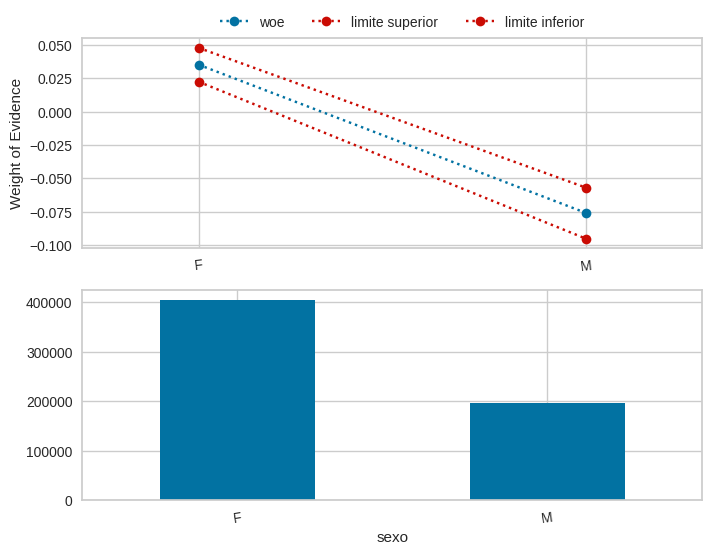

In [29]:
biv_discreta('sexo', df_)

### Posse de Veículo

,qt_bom,qt_mau,mau,posse_de_veiculo,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
posse_de_veiculo,,,,,,,,,,,,,,
N,343778,22515,0.061467,N,366293,0.000397,0.062245,0.060689,-2.725814,-2.712410,-2.739378,0.006877,0.020281,-0.006687
S,219579,14128,0.060452,S,233707,0.000493,0.061418,0.059486,-2.743553,-2.726667,-2.760694,-0.010862,0.006024,-0.028003


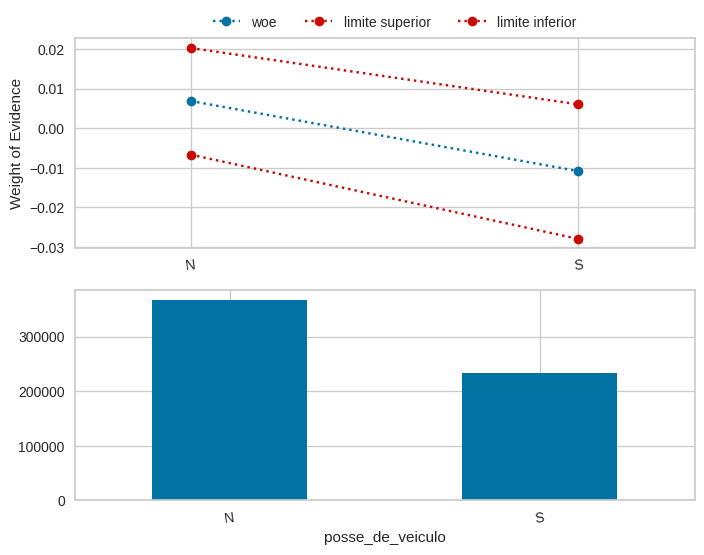

In [30]:
biv_discreta('posse_de_veiculo', df_)

### Posse de Imóvel

,qt_bom,qt_mau,mau,posse_de_imovel,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
posse_de_imovel,,,,,,,,,,,,,,
N,183305,13641,0.069263,N,196946,0.000572,0.070384,0.068141,-2.598071,-2.580806,-2.615598,0.134620,0.151885,0.117093
S,380052,23002,0.057069,S,403054,0.000365,0.057785,0.056353,-2.804727,-2.791496,-2.818114,-0.072036,-0.058805,-0.085423


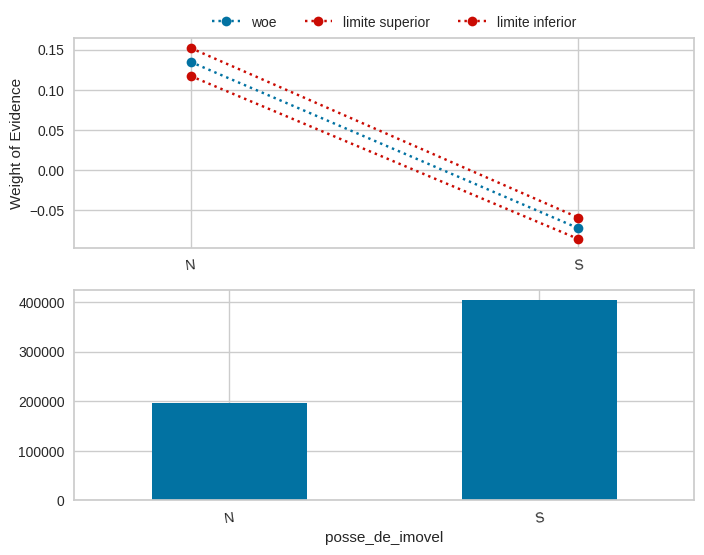

In [31]:
biv_discreta('posse_de_imovel', df_)

### Quantidade de Filhos

,qt_bom,qt_mau,mau,qtd_filhos,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
qtd_filhos,,,,,,,,,,,,,,
0,389129,24753,0.059807,0,413882,0.000369,0.060529,0.059084,-2.754964,-2.742189,-2.767885,-0.022273,-0.009497,-0.035194
1,114547,7924,0.064701,1,122471,0.000703,0.066079,0.063323,-2.671089,-2.648545,-2.694085,0.061602,0.084147,0.038606
2,52182,3421,0.061525,2,55603,0.001019,0.063523,0.059528,-2.724805,-2.690727,-2.759933,0.007886,0.041964,-0.027241
3,6493,467,0.067098,3,6960,0.002999,0.072977,0.061219,-2.632151,-2.541841,-2.730127,0.100540,0.190850,0.002564
4,806,48,0.056206,4,854,0.007881,0.071675,0.040737,-2.820883,-2.561236,-3.159030,-0.088192,0.171455,-0.426339
5,67,10,0.129870,5,77,0.038309,0.206169,0.053571,-1.902108,-1.348173,-2.871687,0.830584,1.384518,-0.138996
7,69,13,0.158537,7,82,0.040334,0.238789,0.078284,-1.669157,-1.159328,-2.465897,1.063534,1.573363,0.266795
14,64,7,0.098592,14,71,0.035379,0.169154,0.028029,-2.212973,-1.591637,-3.546072,0.519718,1.141054,-0.813381


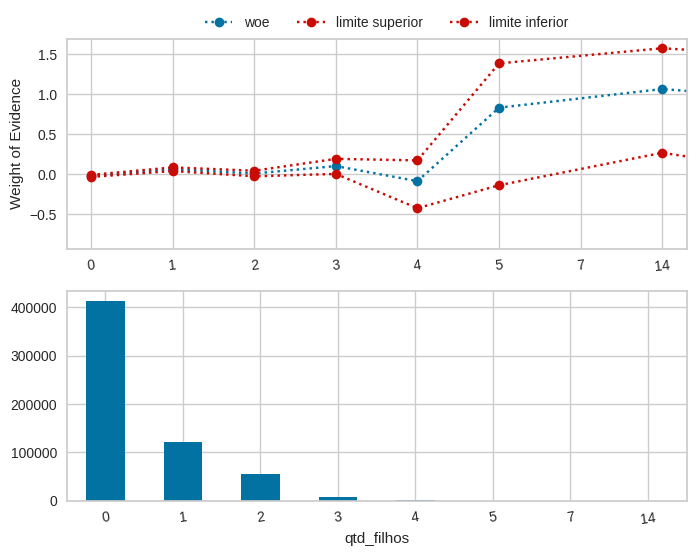

In [32]:
biv_discreta('qtd_filhos', df_)

0.001323320930508114

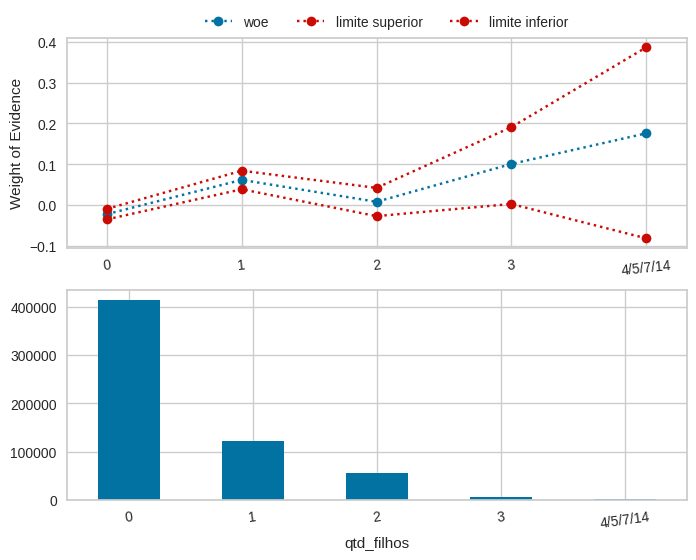

In [33]:
# Agrupando as classes da variável qtd_filhos
df_['qtd_filhos'] = df_['qtd_filhos'].astype(str)

df_.qtd_filhos.replace(
    {'4': '4/5/7/14',
     '5': '4/5/7/14',
     '7': '4/5/7/14',
     '14': '4/5/7/14'}, inplace=True)

biv_discreta('qtd_filhos', df_)
IV(df_.qtd_filhos, df_.mau)

### Tipo de Renda

,qt_bom,qt_mau,mau,tipo_renda,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
tipo_renda,,,,,,,,,,,,,,
Assalariado,288865,19595,0.063525,Assalariado,308460,0.000439,0.064386,0.062665,-2.690685,-2.676307,-2.705246,0.042006,0.056384,0.027445
Bolsista,279,12,0.041237,Bolsista,291,0.011656,0.064178,0.018296,-3.146305,-2.679758,-3.982616,-0.413614,0.052933,-1.249925
Empresário,129935,8206,0.059403,Empresário,138141,0.000636,0.060650,0.058157,-2.762169,-2.740076,-2.784700,-0.029478,-0.007385,-0.052009
Pensionista,94627,6500,0.064276,Pensionista,101127,0.000771,0.065787,0.062764,-2.678141,-2.653280,-2.703552,0.054550,0.079411,0.029139
Servidor público,49651,2330,0.044824,Servidor público,51981,0.000908,0.046603,0.043045,-3.059150,-3.018369,-3.101504,-0.326459,-0.285678,-0.368813


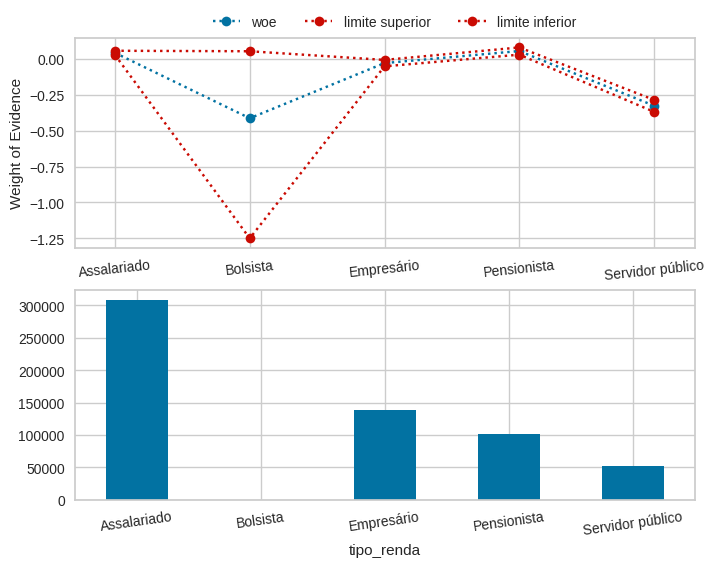

In [34]:
biv_discreta('tipo_renda', df_)

0.009634301334170859

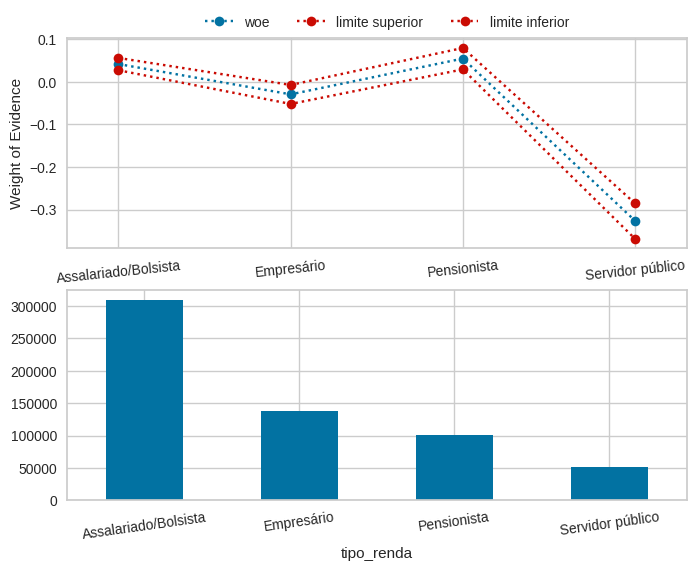

In [35]:
# Agrupando as classes da variável educacao
df_.tipo_renda.replace(
    {'Assalariado': 'Assalariado/Bolsista',
     'Bolsista': 'Assalariado/Bolsista'}, inplace=True)

biv_discreta('tipo_renda', df_)
IV(df_.tipo_renda, df_.mau)

### Educação

,qt_bom,qt_mau,mau,educacao,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
educacao,,,,,,,,,,,,,,
Fundamental,6420,481,0.069700,Fundamental,6901,0.003065,0.075709,0.063691,-2.591306,-2.502130,-2.687900,0.141385,0.230561,0.044791
Médio,379939,25510,0.062918,Médio,405449,0.000381,0.063665,0.062170,-2.700940,-2.688333,-2.713688,0.031751,0.044358,0.019003
Pós graduação,608,43,0.066052,Pós graduação,651,0.009735,0.085167,0.046937,-2.648975,-2.374126,-3.010867,0.083716,0.358565,-0.278176
Superior completo,154354,9086,0.055592,Superior completo,163440,0.000567,0.056703,0.054481,-2.832514,-2.811552,-2.853874,-0.099823,-0.078861,-0.121183
Superior incompleto,22036,1523,0.064646,Superior incompleto,23559,0.001602,0.067786,0.061506,-2.671995,-2.621201,-2.725141,0.060696,0.111490,0.007550


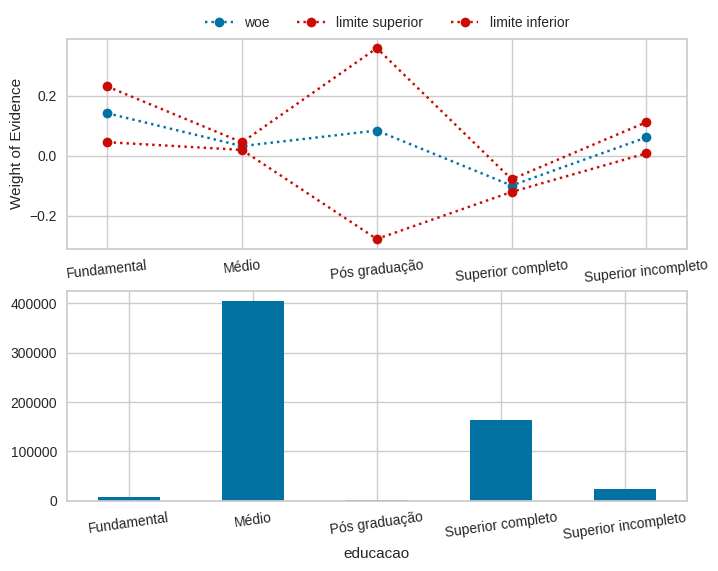

In [36]:
biv_discreta('educacao', df_)

0.0034801108923340892

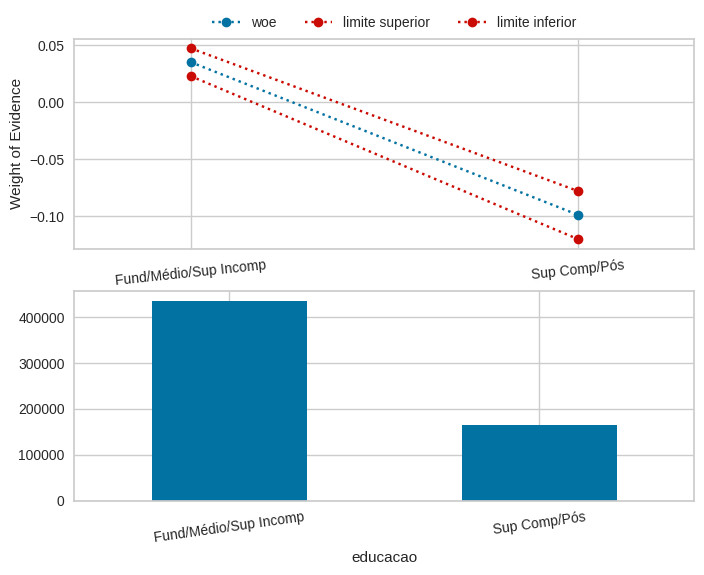

In [37]:
# Agrupando as classes da variável educacao

df_.educacao.replace(
    {'Fundamental': 'Fund/Médio/Sup Incomp',
     'Médio': 'Fund/Médio/Sup Incomp',
     'Superior incompleto': 'Fund/Médio/Sup Incomp',
     'Superior completo': 'Sup Comp/Pós',
     'Pós graduação': 'Sup Comp/Pós'}, inplace=True)

biv_discreta('educacao', df_)
IV(df_.educacao, df_.mau)

### Estado Civil

,qt_bom,qt_mau,mau,estado_civil,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
estado_civil,,,,,,,,,,,,,,
Casado,395880,25269,0.060000,Casado,421149,0.000366,0.060717,0.059283,-2.751533,-2.738886,-2.764322,-0.018842,-0.006195,-0.031631
Separado,31994,2194,0.064175,Separado,34188,0.001325,0.066772,0.061577,-2.679822,-2.637360,-2.723916,0.052869,0.095331,0.008775
Solteiro,68585,4636,0.063315,Solteiro,73221,0.000900,0.065079,0.061551,-2.694222,-2.664858,-2.724359,0.038469,0.067833,0.008332
União,43048,3060,0.066366,União,46108,0.001159,0.068638,0.064094,-2.643901,-2.607801,-2.681168,0.088790,0.124890,0.051523
Viúvo,23850,1484,0.058577,Viúvo,25334,0.001475,0.061469,0.055686,-2.777043,-2.725779,-2.830738,-0.044352,0.006912,-0.098047


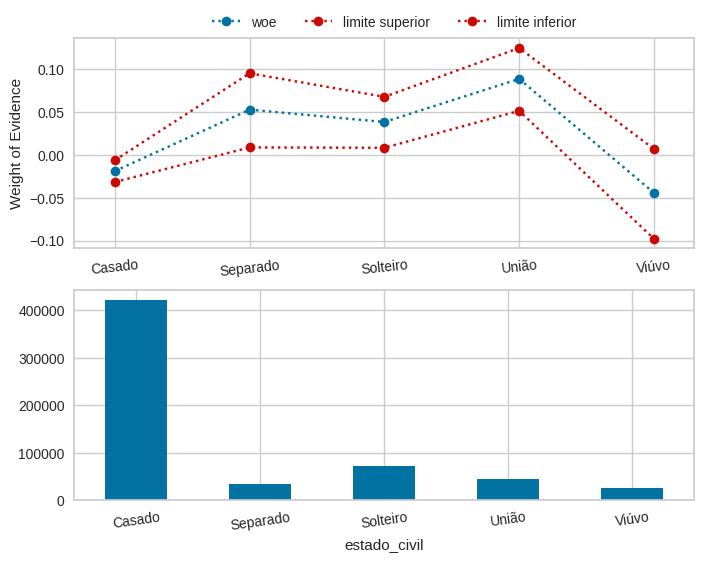

In [38]:
biv_discreta('estado_civil', df_)

### Tipo de Residencia

,qt_bom,qt_mau,mau,tipo_residencia,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
tipo_residencia,,,,,,,,,,,,,,
Aluguel,7666,596,0.072137,Aluguel,8262,0.002846,0.077717,0.066558,-2.554310,-2.473779,-2.640804,0.178382,0.258912,0.091887
Casa,506887,32449,0.060165,Casa,539336,0.000324,0.060799,0.059530,-2.748618,-2.737450,-2.759898,-0.015927,-0.004759,-0.027207
Com os pais,24733,1997,0.074710,Com os pais,26730,0.001608,0.077862,0.071558,-2.516492,-2.471755,-2.563000,0.216199,0.260936,0.169691
Comunitário,2449,185,0.070235,Comunitário,2634,0.004979,0.079999,0.060472,-2.583079,-2.442363,-2.743199,0.149612,0.290329,-0.010508
Estúdio,4071,225,0.052374,Estúdio,4296,0.003399,0.059038,0.045711,-2.895544,-2.768721,-3.038637,-0.162852,-0.036030,-0.305946
Governamental,17551,1191,0.063547,Governamental,18742,0.001782,0.067040,0.060054,-2.690318,-2.633076,-2.750571,0.042373,0.099615,-0.017880


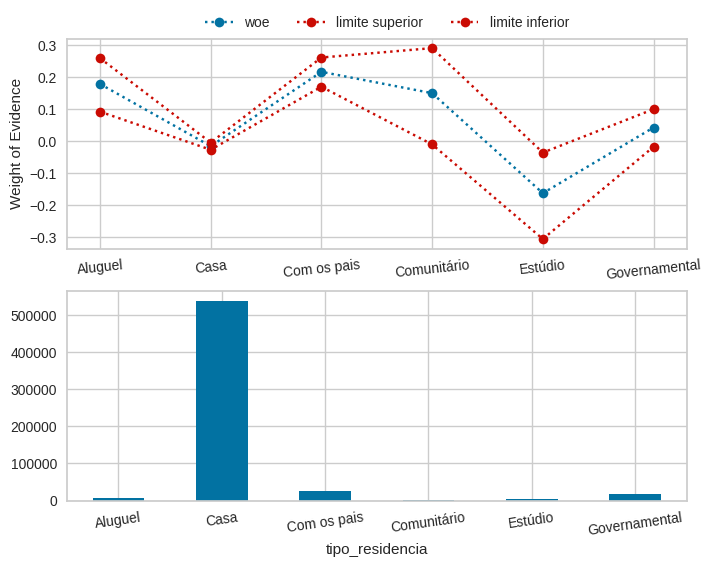

In [39]:
biv_discreta('tipo_residencia', df_)

0.0027708278973644224

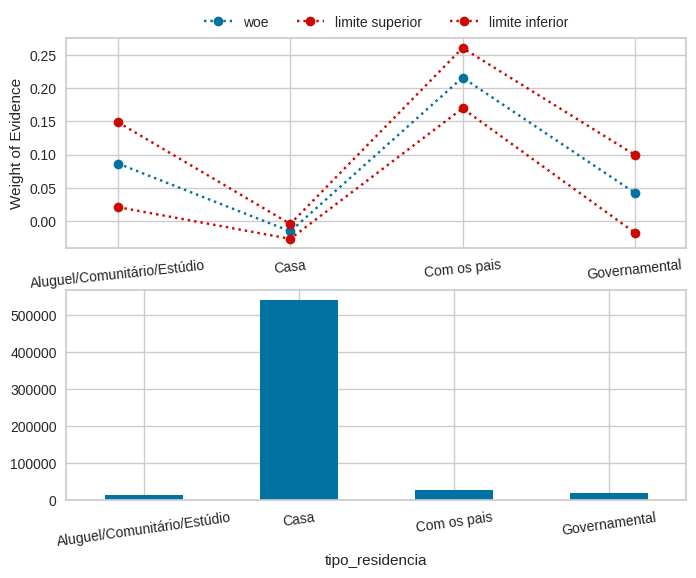

In [40]:
# Agrupando as classes da variável tipo_residencia.

df_.tipo_residencia.replace(
    {'Aluguel': 'Aluguel/Comunitário/Estúdio',
     'Comunitário': 'Aluguel/Comunitário/Estúdio',
     'Estúdio': 'Aluguel/Comunitário/Estúdio'}
     ,inplace=True)

biv_discreta('tipo_residencia', df_)
IV(df_.tipo_residencia, df_.mau)

### Quantidade de Pessoas por Residência

,qt_bom,qt_mau,mau,qt_pessoas_residencia,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
qt_pessoas_residencia,,,,,,,,,,,,,,
1.0,101834,6823,0.062794,1.0,108657,0.000736,0.064236,0.061351,-2.703045,-2.678793,-2.727822,0.029646,0.053898,0.004869
2.0,306954,19227,0.058946,2.0,326181,0.000412,0.059754,0.058138,-2.770382,-2.755904,-2.785048,-0.037691,-0.023213,-0.052357
3.0,97323,6803,0.065334,3.0,104126,0.000766,0.066835,0.063833,-2.660672,-2.636351,-2.685518,0.072019,0.096340,0.047173
4.0,50051,3263,0.061203,4.0,53314,0.001038,0.063238,0.059169,-2.730395,-2.695521,-2.766371,0.002296,0.037170,-0.033680
5.0,6189,449,0.067641,5.0,6638,0.003082,0.073683,0.061599,-2.623506,-2.531442,-2.723540,0.109185,0.201250,0.009151
6.0,832,58,0.065169,6.0,890,0.008274,0.081406,0.048931,-2.663389,-2.423389,-2.967184,0.069302,0.309302,-0.234493
7.0,41,0,0.000000,7.0,41,0.000000,0.000000,0.000000,-inf,-inf,-inf,-inf,-inf,-inf
9.0,69,13,0.158537,9.0,82,0.040334,0.238789,0.078284,-1.669157,-1.159328,-2.465897,1.063534,1.573363,0.266795
15.0,64,7,0.098592,15.0,71,0.035379,0.169154,0.028029,-2.212973,-1.591637,-3.546072,0.519718,1.141054,-0.813381


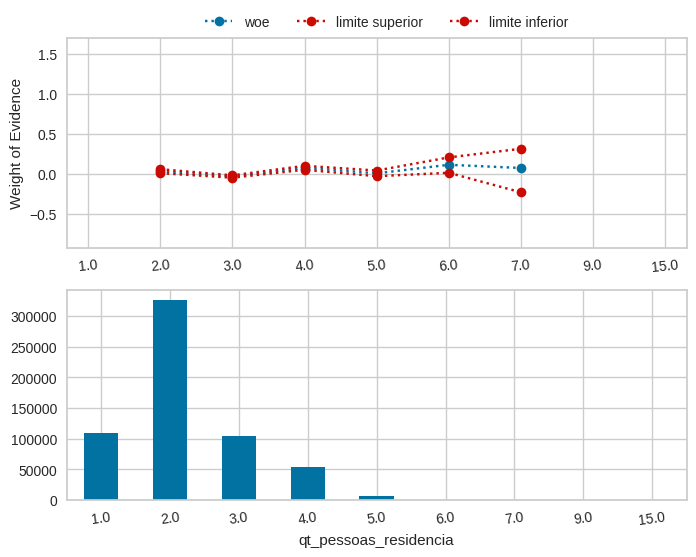

In [41]:
biv_discreta('qt_pessoas_residencia', df_)

## Análise variáveis continuas

In [42]:
def biv_continua(var, ncat, df):
    df['bom'] = 1-df.mau
    cat_srs, bins = pd.qcut(df[var], ncat, retbins=True, precision=0, duplicates='drop')
    g = df.groupby(cat_srs)

    biv = pd.DataFrame({'qt_bom': g['bom'].sum(),
                        'qt_mau': g['mau'].sum(),
                        'mau':g['mau'].mean(),
                        var: g[var].mean(),
                        'cont':g[var].count()})

    biv['ep'] = (biv.mau*(1-biv.mau)/biv.cont)**.5
    biv['mau_sup'] = biv.mau+t.ppf([0.975], biv.cont-1)*biv.ep
    biv['mau_inf'] = biv.mau+t.ppf([0.025], biv.cont-1)*biv.ep

    biv['logit'] = np.log(biv.mau/(1-biv.mau))
    biv['logit_sup'] = np.log(biv.mau_sup/(1-biv.mau_sup))
    biv['logit_inf'] = np.log(biv.mau_inf/(1-biv.mau_inf))

    tx_mau_geral = df.mau.mean()
    woe_geral = np.log(df.mau.mean() / (1 - df.mau.mean()))

    biv['woe'] = biv.logit - woe_geral
    biv['woe_sup'] = biv.logit_sup - woe_geral
    biv['woe_inf'] = biv.logit_inf - woe_geral

    fig, ax = plt.subplots(2,1, figsize=(8,6))
    ax[0].plot(biv[var], biv.woe, ':bo', label='woe')
    ax[0].plot(biv[var], biv.woe_sup, 'o:r', label='limite superior')
    ax[0].plot(biv[var], biv.woe_inf, 'o:r', label='limite inferior')

    num_cat = biv.shape[0]

    ax[0].set_ylabel("Weight of Evidence")
    ax[0].legend(bbox_to_anchor=(.83, 1.17), ncol=3)

    ax[1] = biv.cont.plot.bar()
    return None

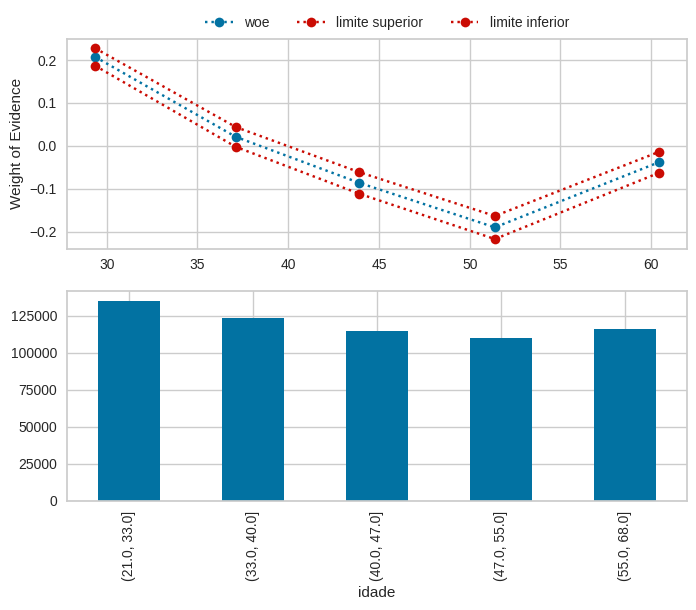

In [43]:
biv_continua('idade', 5, df_)

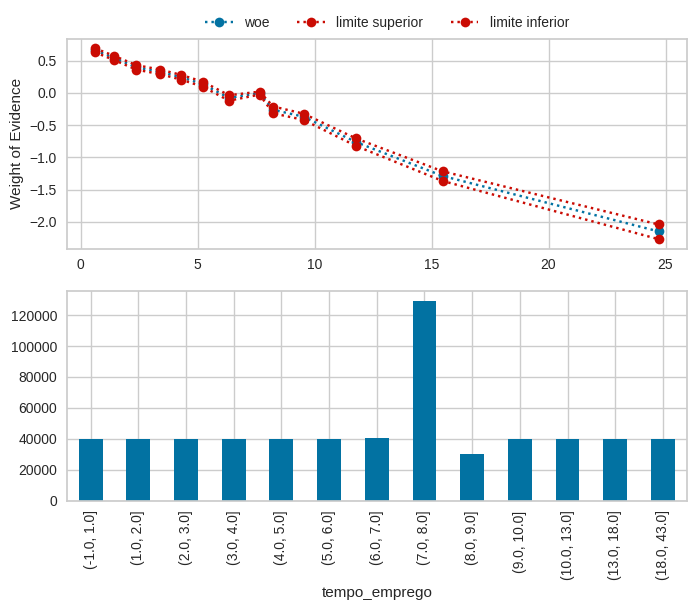

In [44]:
biv_continua('tempo_emprego', 15, df_)

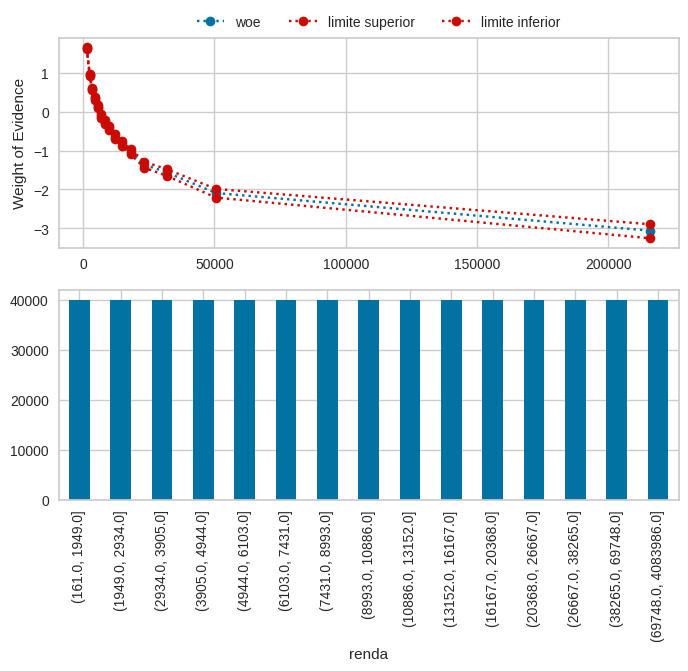

In [45]:
biv_continua('renda', 15, df_)

## Avaliação do modelo

Avalie o poder discriminante do modelo pelo menos avaliando acurácia, KS e Gini.

Avalie estas métricas nas bases de desenvolvimento e *out of time*.

In [46]:
# ajuda para definir a equação da regressão
' + '.join(list(df_.columns))

'sexo + posse_de_veiculo + posse_de_imovel + qtd_filhos + tipo_renda + educacao + estado_civil + tipo_residencia + idade + tempo_emprego + qt_pessoas_residencia + renda + mau + bom'

In [47]:
metadados.sort_values(by='IV', ascending=False)

,dtype,nmissing,valores_unicos,papel,IV,Classificacao_IV
qt_pessoas_residencia,float64,0,9,covariavel,inf,Muito Forte (Suspeito)
renda,float64,0,112472,covariavel,0.959826,Muito Forte (Suspeito)
tempo_emprego,float64,0,3005,covariavel,0.283956,Médio
idade,int64,0,47,covariavel,0.018434,Não Útil
tipo_renda,object,0,5,covariavel,0.009718,Não Útil
posse_de_imovel,object,0,2,covariavel,0.009690,Não Útil
educacao,object,0,5,covariavel,0.003690,Não Útil
tipo_residencia,object,0,6,covariavel,0.003330,Não Útil
sexo,object,0,2,covariavel,0.002665,Não Útil
qtd_filhos,int64,0,8,covariavel,0.001689,Não Útil


Pelo IV, vou considerar renda até posse_de_imovel como variáveis a serem uteis

In [48]:
formula = '''
          mau ~ sexo + posse_de_veiculo + posse_de_imovel + qtd_filhos +
          tipo_renda + educacao + estado_civil + tipo_residencia +
          qt_pessoas_residencia + idade + tempo_emprego + renda
          '''

r1 = smf.glm(formula=formula, data=df_, family=sm.families.Binomial()).fit()
r1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    mau   No. Observations:               600000
Model:                            GLM   Df Residuals:                   599977
Model Family:                Binomial   Df Model:                           22
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.2488e+05
Date:                Thu, 01 Aug 2024   Deviance:                   2.4965e+05
Time:                        01:21:29   Pearson chi2:                 1.57e+16
No. Iterations:                    11   Pseudo R-squ. (CS):            0.04260
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                           -1.4627      0.091    -16.099      0.000      -1.641      -1.285
sexo[T.M]                           -0.1253      0.013     -9.548      0.000      -0.151      -0.100
posse_de_veiculo[T.S]                0.0309      0.012      2.497      0.013       0.007       0.055
posse_de_imovel[T.S]                -0.0846      0.012     -7.167      0.000      -0.108      -0.061
qtd_filhos[T.1]                     -0.0092      0.042     -0.219      0.827      -0.091       0.073
qtd_filhos[T.2]                     -0.0285      0.081     -0.351      0.725      -0.188       0.131
qtd_filhos[T.3]                      0.0528      0.128      0.412      0.680      -0.198       0.304
qtd_filhos[T.4/5/7/14]              -0.0213      0.241     -0.089      0.929      -0.494       0.451
tipo_renda[T.Empresário]            -0.0547      0.014     -3.910      0.000      -0.082      -0.027
tipo_renda[T.Pensionista]           -0.0402      0.020     -1.988      0.047      -0.080      -0.001
tipo_renda[T.Servidor público]      -0.0327      0.023     -1.409      0.159      -0.078       0.013
educacao[T.Sup Comp/Pós]            -0.0567      0.013     -4.332      0.000      -0.082      -0.031
estado_civil[T.Separado]             0.0464      0.045      1.030      0.303      -0.042       0.135
estado_civil[T.Solteiro]             0.0136      0.043      0.319      0.750      -0.070       0.097
estado_civil[T.União]                0.0476      0.020      2.340      0.019       0.008       0.088
estado_civil[T.Viúvo]               -0.0275      0.049     -0.564      0.573      -0.123       0.068
tipo_residencia[T.Casa]             -0.0543      0.034     -1.595      0.111      -0.121       0.012
tipo_residencia[T.Com os pais]      -0.0393      0.041     -0.957      0.338      -0.120       0.041
tipo_residencia[T.Governamental]    -0.0503      0.045     -1.107      0.268      -0.139       0.039
qt_pessoas_residencia                0.0087      0.039      0.222      0.824      -0.068       0.086
idade                                0.0001      0.001      0.186      0.853      -0.001       0.002
tempo_emprego                       -0.0235      0.002    -13.048      0.000      -0.027      -0.020
renda                               -0.0001   1.09e-06    -93.689      0.000      -0.000   -9.96e-05
====================================================================================================
"""

qtd_filhos, estado_civil, tipo_residencia e qtd_pessoas_residencia serão os primeiros a serem removidos, porque possue IV e P>value ruins. E irei já colocar renda em logarítimo, o std erros está MUITO baixo

In [49]:
formula = '''
          mau ~ sexo + posse_de_veiculo + posse_de_imovel +
          tipo_renda + educacao + idade + tempo_emprego + np.log(renda)
          '''

r2 = smf.glm(formula=formula, data=df_, family=sm.families.Binomial()).fit()
r2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    mau   No. Observations:               600000
Model:                            GLM   Df Residuals:                   599989
Model Family:                Binomial   Df Model:                           10
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.2027e+05
Date:                Thu, 01 Aug 2024   Deviance:                   2.4054e+05
Time:                        01:21:42   Pearson chi2:                 5.98e+05
No. Iterations:                     7   Pseudo R-squ. (CS):            0.05721
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                          5.8775      0.056    104.098      0.000       5.767       5.988
sexo[T.M]                         -0.0084      0.013     -0.627      0.530      -0.035       0.018
posse_de_veiculo[T.S]              0.0283      0.012      2.267      0.023       0.004       0.053
posse_de_imovel[T.S]              -0.0205      0.012     -1.732      0.083      -0.044       0.003
tipo_renda[T.Empresário]          -0.0028      0.014     -0.200      0.842      -0.031       0.025
tipo_renda[T.Pensionista]          0.0023      0.020      0.116      0.908      -0.037       0.042
tipo_renda[T.Servidor público]     0.0048      0.024      0.203      0.839      -0.041       0.051
educacao[T.Sup Comp/Pós]          -0.0056      0.013     -0.422      0.673      -0.032       0.020
idade                              0.0009      0.001      1.285      0.199      -0.000       0.002
tempo_emprego                     -0.0018      0.002     -1.047      0.295      -0.005       0.002
np.log(renda)                     -0.9877      0.007   -148.819      0.000      -1.001      -0.975
==================================================================================================
"""

Agora vou remover sexo, tipo_renda e educação por serem P>value mais altos

In [50]:
formula = '''
          mau ~ posse_de_veiculo + posse_de_imovel
          + idade + tempo_emprego + np.log(renda)
          '''

r3 = smf.glm(formula=formula, data=df_, family=sm.families.Binomial()).fit()
r3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    mau   No. Observations:               600000
Model:                            GLM   Df Residuals:                   599994
Model Family:                Binomial   Df Model:                            5
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.2027e+05
Date:                Thu, 01 Aug 2024   Deviance:                   2.4054e+05
Time:                        01:21:48   Pearson chi2:                 5.98e+05
No. Iterations:                     7   Pseudo R-squ. (CS):            0.05721
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 5.8748      0.056    105.705      0.000       5.766       5.984
posse_de_veiculo[T.S]     0.0251      0.012      2.150      0.032       0.002       0.048
posse_de_imovel[T.S]     -0.0202      0.012     -1.710      0.087      -0.043       0.003
idade                     0.0010      0.001      1.893      0.058   -3.46e-05       0.002
tempo_emprego            -0.0017      0.002     -0.974      0.330      -0.005       0.002
np.log(renda)            -0.9885      0.007   -151.447      0.000      -1.001      -0.976
=========================================================================================
"""

Seguindo mesma lógica

In [51]:
formula = '''
          mau ~ posse_de_veiculo + np.log(renda)
          '''

r4 = smf.glm(formula=formula, data=df_, family=sm.families.Binomial()).fit()
r4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    mau   No. Observations:               600000
Model:                            GLM   Df Residuals:                   599997
Model Family:                Binomial   Df Model:                            2
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.2027e+05
Date:                Thu, 01 Aug 2024   Deviance:                   2.4055e+05
Time:                        01:21:51   Pearson chi2:                 5.97e+05
No. Iterations:                     7   Pseudo R-squ. (CS):            0.05720
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 5.9185      0.049    121.064      0.000       5.823       6.014
posse_de_veiculo[T.S]     0.0222      0.012      1.929      0.054      -0.000       0.045
np.log(renda)            -0.9912      0.006   -169.804      0.000      -1.003      -0.980
=========================================================================================
"""

In [52]:
df_['score'] = r4.predict(df_)

# Acurácia
acc = metrics.accuracy_score(df_.mau, df_.score>.068)
#AUC
fpr, tpr, thresholds = metrics.roc_curve(df_.mau, df_.score)
auc = metrics.auc(fpr, tpr)
#Gini
gini = 2*auc -1
ks = ks_2samp(df_.loc[df_.mau == 1, 'score'], df_.loc[df_.mau != 1, 'score']).statistic

print('Acurácia: {0:.1%} \nAUC: {1:.1%} \nGINI: {2:.1%}\nKS: {3:.1%}'
      .format(acc, auc, gini, ks))


Acurácia: 71.9% 
AUC: 77.0% 
GINI: 54.0%
KS: 39.8%


## Aplicação na base OOT

In [53]:
df_oot.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 150000 entries, 2016-01-01 to 2016-03-01
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   index                  150000 non-null  int64  
 1   sexo                   150000 non-null  object 
 2   posse_de_veiculo       150000 non-null  object 
 3   posse_de_imovel        150000 non-null  object 
 4   qtd_filhos             150000 non-null  int64  
 5   tipo_renda             150000 non-null  object 
 6   educacao               150000 non-null  object 
 7   estado_civil           150000 non-null  object 
 8   tipo_residencia        150000 non-null  object 
 9   idade                  150000 non-null  int64  
 10  tempo_emprego          124918 non-null  float64
 11  qt_pessoas_residencia  150000 non-null  float64
 12  renda                  150000 non-null  float64
 13  mau                    150000 non-null  bool   
dtypes: bool(1), float64(

In [54]:
df_oot['tempo_emprego'] = df_oot['tempo_emprego'].fillna(df_oot['tempo_emprego'].mean())

# Refazendo o que foi feito na base de treino
df_oot['qtd_filhos'] = df_oot['qtd_filhos'].astype(str)

df_oot.qtd_filhos.replace({'4': '4/5/7/14',
                           '5': '4/5/7/14',
                           '7': '4/5/7/14',
                           '14': '4/5/7/14'}, inplace=True)

df_oot.tipo_renda.replace({'Assalariado': 'Assalariado/Bolsista',
                           'Bolsista': 'Assalariado/Bolsista'}, inplace=True)

df_oot.educacao.replace({'Fundamental': 'Fund/Médio/Sup Incomp',
                           'Médio': 'Fund/Médio/Sup Incomp',
                           'Superior incompleto': 'Fund/Médio/Sup Incomp',
                           'Superior completo': 'Sup Comp/Pós',
                           'Pós graduação': 'Sup Comp/Pós'}, inplace=True)

df_oot.tipo_residencia.replace({'Aluguel': 'Aluguel/Comunitário/Estúdio',
                                  'Comunitário': 'Aluguel/Comunitário/Estúdio',
                                  'Estúdio': 'Aluguel/Comunitário/Estúdio'}
                                 ,inplace=True)

df_oot.qt_pessoas_residencia = df_oot.qt_pessoas_residencia.astype(str)

df_oot.qt_pessoas_residencia.replace({'5.0': '5/6/7/8/9/15',
                                        '6.0': '5/6/7/8/9/15',
                                        '7.0': '5/6/7/8/9/15',
                                        '8.0': '5/6/7/8/9/15',
                                        '9.0': '5/6/7/8/9/15',
                                        '15.0': '5/6/7/8/9/15'}, inplace=True)

In [55]:
df_oot['score'] = r4.predict(df_oot)

# Acurácia
acc = metrics.accuracy_score(df_oot.mau, df_oot.score>.068)
#AUC
fpr, tpr, thresholds = metrics.roc_curve(df_oot.mau, df_oot.score)
auc = metrics.auc(fpr, tpr)
#Gini
gini = 2*auc -1
ks = ks_2samp(df_oot.loc[df_oot.mau == 1, 'score'], df_oot.loc[df_oot.mau != 1, 'score']).statistic

print('Acurácia: {0:.1%} \nAUC: {1:.1%} \nGINI: {2:.1%}\nKS: {3:.1%}'
      .format(acc, auc, gini, ks))

Acurácia: 39.2% 
AUC: 73.9% 
GINI: 47.8%
KS: 34.6%


#Criar um pipeline utilizando o sklearn pipeline

In [56]:
df_pipeline = df.sample(50000)
#df_pipeline = df.copy()
df_pipeline['tempo_emprego'] = df_pipeline['tempo_emprego'].fillna(df_pipeline['tempo_emprego'].mean())

In [57]:
df_pipeline.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 50000 entries, 2015-05-01 to 2015-04-01
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   index                  50000 non-null  int64  
 1   sexo                   50000 non-null  object 
 2   posse_de_veiculo       50000 non-null  object 
 3   posse_de_imovel        50000 non-null  object 
 4   qtd_filhos             50000 non-null  int64  
 5   tipo_renda             50000 non-null  object 
 6   educacao               50000 non-null  object 
 7   estado_civil           50000 non-null  object 
 8   tipo_residencia        50000 non-null  object 
 9   idade                  50000 non-null  int64  
 10  tempo_emprego          50000 non-null  float64
 11  qt_pessoas_residencia  50000 non-null  float64
 12  renda                  50000 non-null  float64
 13  mau                    50000 non-null  bool   
dtypes: bool(1), float64(3), int64(3), obj

## Pré processamento

In [58]:
df_pipeline.reset_index(inplace=True)
df_pipeline.drop(columns=['data_ref', 'index'], inplace=True)
df_pipeline.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   sexo                   50000 non-null  object 
 1   posse_de_veiculo       50000 non-null  object 
 2   posse_de_imovel        50000 non-null  object 
 3   qtd_filhos             50000 non-null  int64  
 4   tipo_renda             50000 non-null  object 
 5   educacao               50000 non-null  object 
 6   estado_civil           50000 non-null  object 
 7   tipo_residencia        50000 non-null  object 
 8   idade                  50000 non-null  int64  
 9   tempo_emprego          50000 non-null  float64
 10  qt_pessoas_residencia  50000 non-null  float64
 11  renda                  50000 non-null  float64
 12  mau                    50000 non-null  bool   
dtypes: bool(1), float64(3), int64(2), object(7)
memory usage: 4.6+ MB


In [59]:
data = df_pipeline.sample(frac=0.95, random_state=786)
data_unseen = df_pipeline.drop(data.index)
data.reset_index(inplace=True, drop=True)
data_unseen.reset_index(inplace=True, drop=True)
print('Conjunto de dados para modelagem (treino e teste): ' + str(data.shape))
print('Conjunto de dados não usados no treino/teste, apenas como validação: ' + str(data_unseen.shape))

Conjunto de dados para modelagem (treino e teste): (47500, 13)
Conjunto de dados não usados no treino/teste, apenas como validação: (2500, 13)


In [60]:
#forçando a variável qnt de filhos como numérica
data.qtd_filhos = data.qtd_filhos.astype(float)

### Treinar um modelo de regressão logistica com o resultado

In [61]:
X = data.drop(columns=['mau'])
y = data.mau

X = pd.get_dummies(X, columns=['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

# Define a PCA to Linear dimensionality reduction
pca_pipe = PCA(n_components=5)

# Define a Standard Scaler to normalize inputs
scaler_pipe = StandardScaler()

# set the tolerance to a large value to make the example faster
logistic_pipe = LogisticRegression(max_iter=200)

In [62]:
pipe = Pipeline(steps=[("scaler", scaler_pipe),
                       ("pca", pca_pipe),
                       ("logistic", logistic_pipe)])

In [63]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=5)),
                ('logistic', LogisticRegression(max_iter=200))])

In [64]:
pipe.score(X_test, y_test)

0.9275087719298246

In [65]:
reg = setup(data = data, target = 'mau', experiment_name='credit_1',
            normalize=True, normalize_method='zscore', transformation=True,
            transformation_method = 'quantile',fix_imbalance=True)

,Description,Value
0,Session id,2056
1,Target,mau
2,Target type,Binary
3,Original data shape,"(47500, 13)"
4,Transformed data shape,"(75656, 34)"
5,Transformed train set shape,"(61406, 34)"
6,Transformed test set shape,"(14250, 34)"
7,Numeric features,5
8,Categorical features,7
9,Preprocess,True


In [66]:
melhor_modelo = compare_models(fold=4, sort='AUC')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.9215,0.7637,0.0381,0.3755,0.0692,0.0558,0.0995,5.5800
gbc,Gradient Boosting Classifier,0.9212,0.7618,0.0377,0.3642,0.0679,0.0544,0.0959,14.9650
lr,Logistic Regression,0.9171,0.7560,0.1040,0.3600,0.1613,0.1314,0.1602,2.7425
ada,Ada Boost Classifier,0.9137,0.7531,0.0840,0.2848,0.1280,0.0971,0.1180,3.8450
xgboost,Extreme Gradient Boosting,0.9183,0.7345,0.0546,0.3133,0.0928,0.0716,0.1032,1.9775
lda,Linear Discriminant Analysis,0.9205,0.7096,0.0467,0.3607,0.0826,0.0660,0.1065,0.7975
ridge,Ridge Classifier,0.9206,0.7094,0.0491,0.3732,0.0864,0.0696,0.1117,0.6825
rf,Random Forest Classifier,0.9016,0.6941,0.0856,0.1880,0.1176,0.0731,0.0795,7.0900
svm,SVM - Linear Kernel,0.9230,0.6825,0.0059,0.1014,0.0111,0.0087,0.0179,0.8825
nb,Naive Bayes,0.1140,0.6578,0.9788,0.0781,0.1447,0.0033,0.0294,0.6800


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

In [67]:
print(melhor_modelo)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=2056, reg_alpha=0.0, reg_lambda=0.0, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)


In [68]:
gbc = create_model('gbc')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9194,0.7474,0.0433,0.3056,0.0759,0.0580,0.0903
1,0.9212,0.7718,0.0551,0.3889,0.0966,0.0791,0.1231
2,0.9233,0.7307,0.0315,0.4706,0.0590,0.0499,0.1064
3,0.9215,0.7678,0.0353,0.3750,0.0645,0.0520,0.0956
4,0.9218,0.7451,0.0431,0.4074,0.0780,0.0643,0.1125
5,0.9230,0.7990,0.0392,0.4762,0.0725,0.0615,0.1197
6,0.9197,0.7542,0.0392,0.3125,0.0697,0.0535,0.0874
7,0.9206,0.7753,0.0353,0.3333,0.0638,0.0499,0.0873
8,0.9218,0.7700,0.0431,0.4074,0.0780,0.0643,0.1125


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

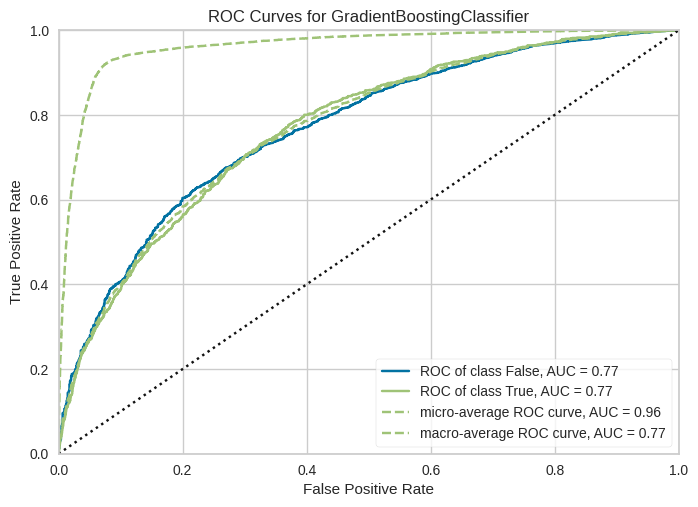

In [69]:
plot_model(gbc, plot = 'auc')

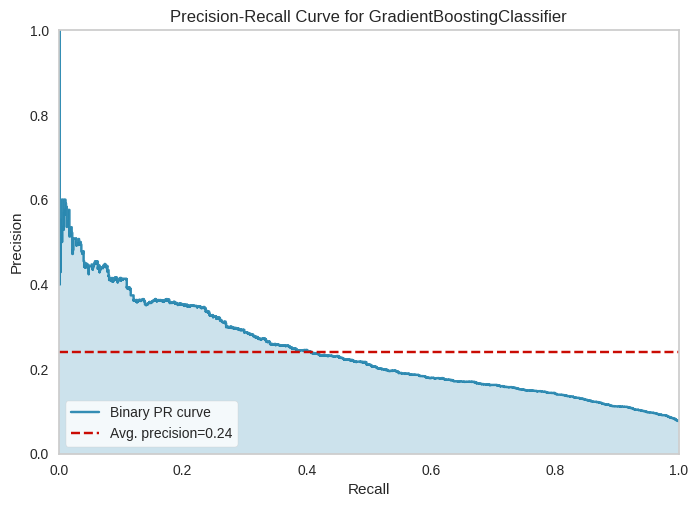

In [70]:
plot_model(gbc, plot = 'pr')

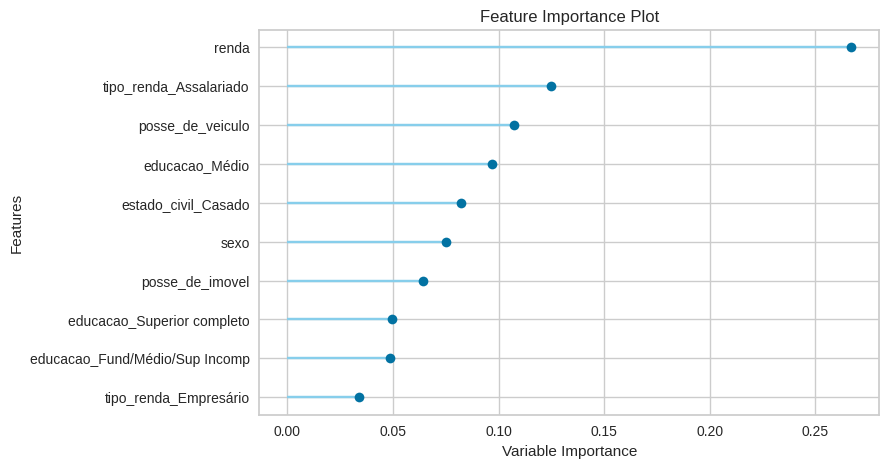

In [71]:
plot_model(gbc, plot='feature')

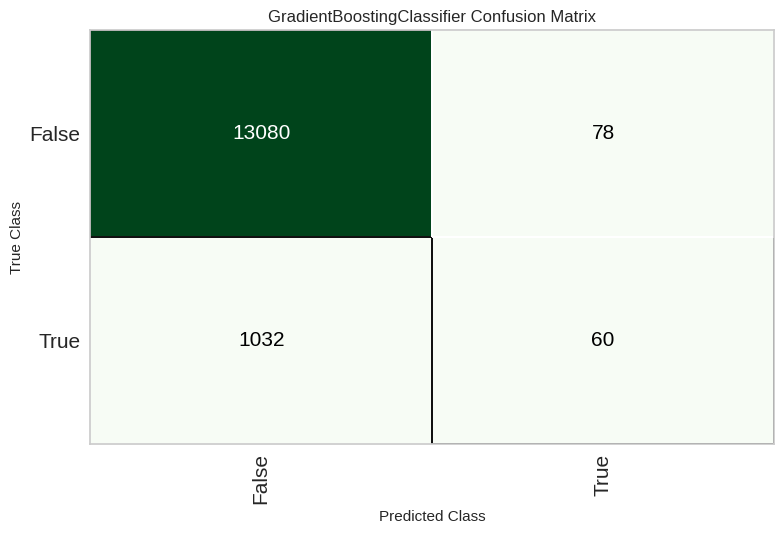

In [72]:
plot_model(gbc, plot = 'confusion_matrix')

### Salvar o pickle file do modelo treinado

In [73]:
import pickle

nome_arquivo = 'model_final.pkl'
pickle.dump(melhor_modelo, open(nome_arquivo, 'wb'))

In [91]:
from google.colab import files

# Baixar o arquivo salvo
files.download('model_final.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Pycaret na base de dados

Utilize o pycaret para pre processar os dados e rodar o modelo **lightgbm**. Faça todos os passos a passos da aula e gere os gráficos finais. E o pipeline de toda a transformação.



In [74]:
lightgbm = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9230,0.7568,0.0354,0.4500,0.0657,0.0552,0.1094
1,0.9227,0.7674,0.0551,0.4516,0.0982,0.0830,0.1370
2,0.9224,0.7294,0.0276,0.3889,0.0515,0.0418,0.0868
3,0.9212,0.7637,0.0353,0.3600,0.0643,0.0513,0.0927
4,0.9200,0.7473,0.0314,0.2963,0.0567,0.0427,0.0747
5,0.9236,0.8008,0.0353,0.5294,0.0662,0.0571,0.1220
6,0.9206,0.7530,0.0392,0.3448,0.0704,0.0556,0.0945
7,0.9215,0.7738,0.0392,0.3846,0.0712,0.0578,0.1027
8,0.9212,0.7676,0.0314,0.3478,0.0576,0.0454,0.0850


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [75]:
tuned_gbm = tune_model(lightgbm)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9215,0.7445,0.0118,0.2308,0.0225,0.0151,0.0364
1,0.9215,0.7694,0.0354,0.3600,0.0645,0.0515,0.0929
2,0.9254,0.7292,0.0315,0.8000,0.0606,0.0551,0.1496
3,0.9233,0.7526,0.0235,0.5000,0.0449,0.0383,0.0957
4,0.9218,0.7393,0.0235,0.3529,0.0441,0.0349,0.0744
5,0.9224,0.7967,0.0196,0.3846,0.0373,0.0301,0.0725
6,0.9227,0.7449,0.0235,0.4286,0.0446,0.0369,0.0860
7,0.9230,0.7695,0.0314,0.4706,0.0588,0.0497,0.1061
8,0.9236,0.7498,0.0314,0.5333,0.0593,0.0512,0.1155


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


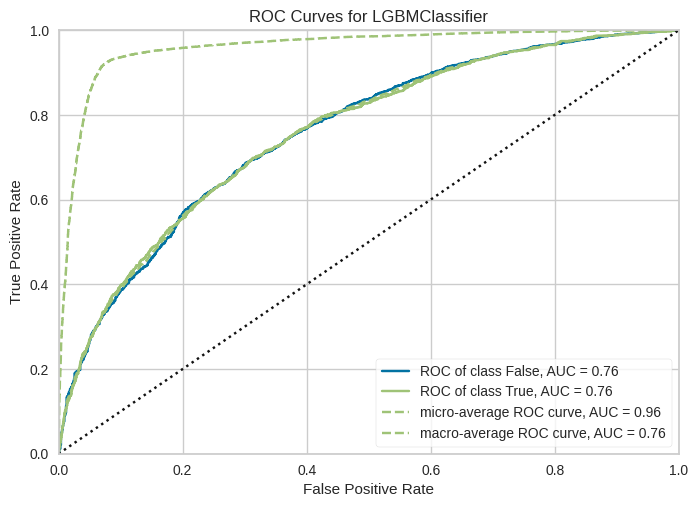

In [76]:
plot_model(tuned_gbm, plot = 'auc')

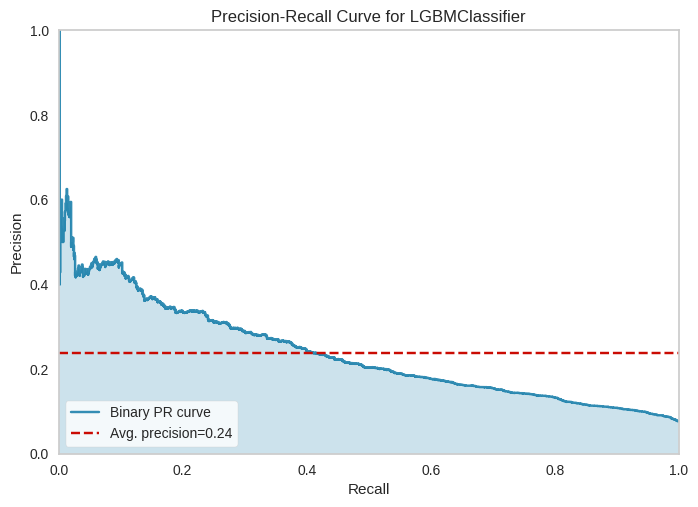

In [77]:
plot_model(tuned_gbm, plot = 'pr')

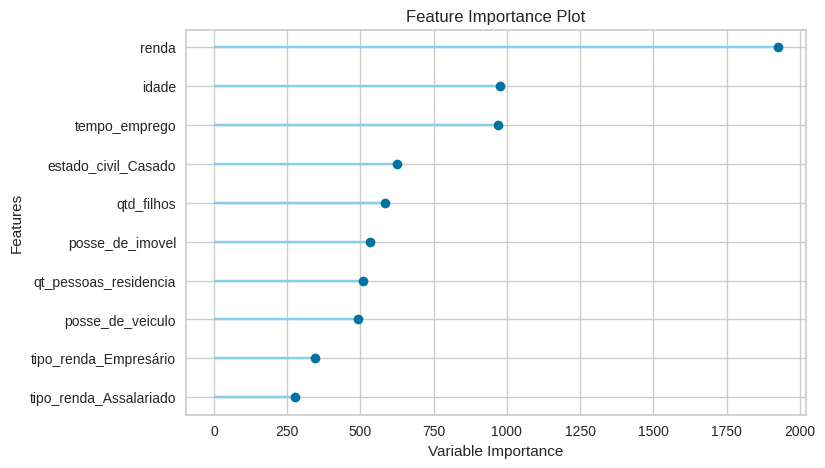

In [78]:
plot_model(tuned_gbm, plot='feature')

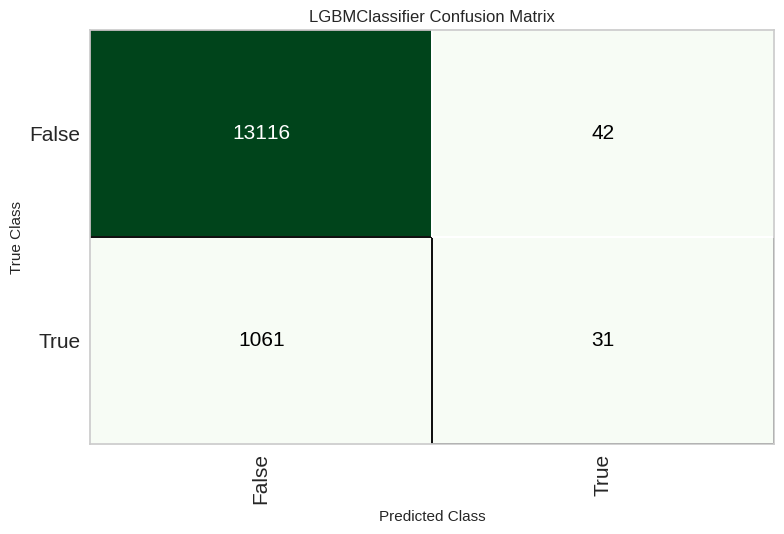

In [79]:
plot_model(tuned_gbm, plot = 'confusion_matrix')

In [80]:
evaluate_model(tuned_gbm)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [81]:
predict_model(tuned_gbm);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.9226,0.7585,0.0284,0.4247,0.0532,0.0440,0.0939


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5


In [85]:
final_gbm = finalize_model(tuned_gbm)

In [86]:
print(final_gbm)

Pipeline(memory=Memory(location=None),
         steps=[('numerical_imputer',
                 TransformerWrapper(exclude=None,
                                    include=['qtd_filhos', 'idade',
                                             'tempo_emprego',
                                             'qt_pessoas_residencia', 'renda'],
                                    transformer=SimpleImputer(add_indicator=False,
                                                              copy=True,
                                                              fill_value=None,
                                                              keep_empty_features=False,
                                                              missing_values=nan,
                                                              strategy='mean'))),
                ('categorical_imputer',
                 TransformerWra...
                                boosting_type='gbdt', class_weight=None,
                           

In [87]:
unseen_predictions = predict_model(final_gbm, data=data_unseen)
unseen_predictions.head()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.9200,0.7453,0.0254,0.3846,0.0476,0.0382,0.0821


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5


,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau,prediction_label,prediction_score
0,F,S,S,0,Pensionista,Superior completo,Casado,Casa,60,7.711755,2.0,46350.941406,False,0,0.5298
1,F,N,S,0,Assalariado/Bolsista,Fund/Médio/Sup Incomp,Casado,Casa,36,2.128767,2.0,1480.130005,True,0,0.5112
2,F,N,S,0,Pensionista,Superior completo,Casado,Casa,58,7.711755,2.0,7451.779785,True,0,0.5280
3,F,N,N,0,Assalariado,Médio,Casado,Casa,46,15.087671,2.0,55115.488281,False,0,0.5302
4,M,N,S,0,Assalariado,Superior incompleto,Solteiro,Casa,27,0.293151,1.0,8623.280273,False,0,0.5238


### Salvar o arquivo do modelo treinado

In [88]:
save_model(final_gbm,'Final GBM Model 31JuL2024')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['qtd_filhos', 'idade',
                                              'tempo_emprego',
                                              'qt_pessoas_residencia', 'renda'],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_value=None,
                                                               keep_empty_features=False,
                                                               missing_values=nan,
                                                               strategy='mean'))),
                 ('categorical_imputer',
                  TransformerWra...
                                 boosting_type='gbdt', class_weight=None,
            

In [90]:
# Baixar o arquivo salvo
files.download('Final GBM Model 31JuL2024.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Projeto Final

1. Subir no GITHUB todos os jupyter notebooks/códigos que você desenvolveu nesse ultimo módulo
1. Gerar um arquivo python (.py) com todas as funções necessárias para rodar no streamlit a escoragem do arquivo de treino
    - Criar um .py
    - Criar um carregador de csv no streamlit
    - Subir um csv no streamlit
    - Criar um pipeline de pré processamento dos dados
    - Utilizar o modelo treinado para escorar a base
        - nome_arquivo = 'model_final.pkl'
1. Gravar um vídeo da tela do streamlit em funcionamento (usando o próprio streamlit (temos aula disso) ou qlqr outra forma de gravação).
1. Subir no Github o vídeo de funcionamento da ferramenta como README.md.
1. Subir no Github os códigos desenvolvidos.
1. Enviar links do github para o tutor corrigir.